# 1. Load the data

In [1]:
import pandas as pd # pandas for data manipulation / analysis
import numpy as np # numpy for math
import matplotlib.pyplot as plt # pyplot for plotting and visualization
import datetime # datetime for computing times
import seaborn as sns # fancier plots

/Users/katherineli/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8 # set figsize for all future plots

In [3]:
# load data

data = pd.read_csv('/Users/katherineli/Downloads/daily_contract_production (1).csv', header = None)
data.columns = ['holding_company_id', 'project_company_id', 'contract_id', 'size_kwdc', 'created_on', \
                'updated_on', 'production_date', 'ato_date', 'actual_kwh', 'expected_kwh', \
                'weather_adjusted_expected_kwh']
extra = pd.read_csv('/Users/katherineli/Downloads/d_contracts.csv')

union = data.join(extra.set_index('id'), on = 'contract_id', rsuffix="DROP").filter(regex="^(?!.*DROP)")

union.head()

,holding_company_id,project_company_id,contract_id,size_kwdc,created_on,updated_on,production_date,ato_date,actual_kwh,expected_kwh,...,host_type,revenue_type,interconnection_type,registry_facility_name,cref_short_name,subscriber_orginization,system_yield_as_built,system_yield_finance,annual_degradation_engr,annual_degradation_finance
0,15,44,4FbAzTVD,25.13,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01 00:00:00.000000,2018-11-29,NaN,42.908097,...,C&I,NEM,NEM,NON241648,NaN,NaN,1131.0,1131.0,0.005,NaN
1,14,50,56XBWDhT,40.00,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01 00:00:00.000000,2018-09-28,NaN,71.340590,...,C&I,NEM,NEM,NON241695,NaN,NaN,954.7,1170.0,0.005,0.005
2,28,71,5Q6T8Cm7,6.70,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01 00:00:00.000000,2018-11-28,0.139945,12.643548,...,Residential,NEM,NEM,NON241642,NaN,NaN,1250.0,1250.0,0.005,0.005
3,14,43,8EaZmYXK,26.18,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01 00:00:00.000000,2018-03-10,23.113000,50.342822,...,C&I,CREF,CREF,NON241367,NCS07,Arcadia,1240.8,1327.0,0.005,NaN
4,15,44,8GniqiNd,77.52,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01 00:00:00.000000,2018-07-12,NaN,142.074655,...,C&I,NEM,NEM,NON241708,NaN,NaN,1214.0,1214.0,0.005,NaN


In [4]:
# extract column info (types, values, etc.)

union.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84216 entries, 0 to 84215
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   holding_company_id             84216 non-null  int64  
 1   project_company_id             84216 non-null  int64  
 2   contract_id                    84216 non-null  object 
 3   size_kwdc                      84216 non-null  float64
 4   created_on                     84216 non-null  object 
 5   updated_on                     84148 non-null  object 
 6   production_date                84216 non-null  object 
 7   ato_date                       84216 non-null  object 
 8   actual_kwh                     80982 non-null  float64
 9   expected_kwh                   84216 non-null  float64
 10  weather_adjusted_expected_kwh  84216 non-null  float64
 11  site_id                        84216 non-null  int64  
 12  in_service_date                41423 non-null 

In [5]:
# convert time-bearing columns to times (originally objects)

for i in range(4, 8):
    union[union.columns[i]] = pd.to_datetime(union[union.columns[i]])
    
union[union.columns[12]] = pd.to_datetime(union[union.columns[12]])
    
union.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84216 entries, 0 to 84215
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   holding_company_id             84216 non-null  int64         
 1   project_company_id             84216 non-null  int64         
 2   contract_id                    84216 non-null  object        
 3   size_kwdc                      84216 non-null  float64       
 4   created_on                     84216 non-null  datetime64[ns]
 5   updated_on                     84148 non-null  datetime64[ns]
 6   production_date                84216 non-null  datetime64[ns]
 7   ato_date                       84216 non-null  datetime64[ns]
 8   actual_kwh                     80982 non-null  float64       
 9   expected_kwh                   84216 non-null  float64       
 10  weather_adjusted_expected_kwh  84216 non-null  float64       
 11  site_id        

In [6]:
union['subscriber_orginization'].value_counts()

Arcadia        6442
CleanChoice    6291
Name: subscriber_orginization, dtype: int64

# 2. Basic exploratory analysis

Examining the 'holding_company_id' column, we find that contracts, total system size, and amount of data are all pretty unevenly distributed between holding companies. This finding, itself, is not surprising, but the discrepancy between the three measures may be interesting to note. 

For example, holding company 3 may not have many contracts, but they have a large mass of solar system which produces a lot of data. 

Holding companies 5, 8, and 14 have a lot of data from many smaller contracts. 

Holding companies 24, 30, 32, 36 have many small contracts, but not a lot of data points.

From the 'project_company_id' column, company 6 dominates in size, few large contracts with a lot of data. 

Projects 10 and 37 have a number of large to medium sized contracts with a lot of data.

Projects 43, 44, and 56 have a lot of data with less size and less contracts.

Projects 41, 48, 54, 77, and 85 have many small contracts with not very much data.

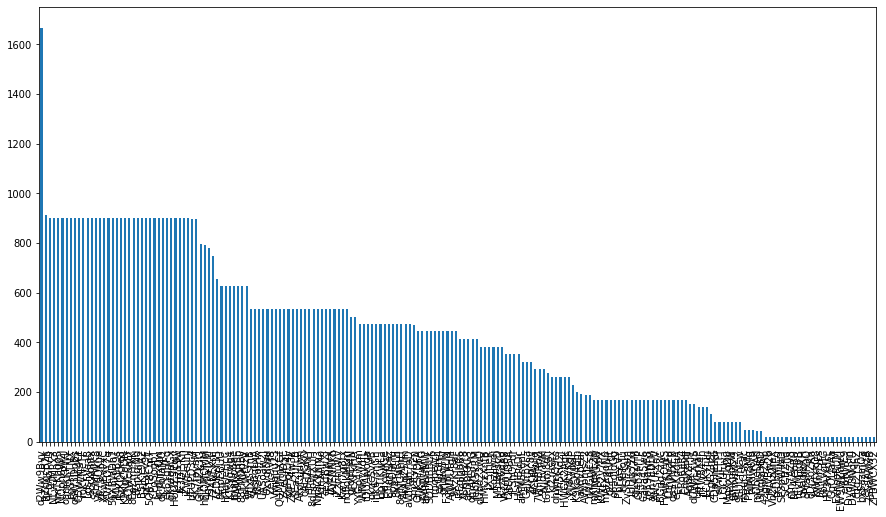

In [7]:
# plot how much data we have from each contract

contracts = union['contract_id'].value_counts() # count data points per contract and store it
contracts.plot(kind = 'bar', figsize = (15, 8))

Examining a simple count of contract IDs, we find many modes - 899 makes sense because data started being collected only on Jan 1, 2019 (899 days before this dataset was extracted), but others may be abnormal.

In [8]:
contracts.value_counts()[contracts.value_counts() > 1]

899    34
18     27
535    24
169    23
475    13
444    10
79      7
626     7
383     6
261     5
414     5
353     4
49      3
322     3
291     3
138     3
504     2
44      2
898     2
153     2
186     2
Name: contract_id, dtype: int64

In [9]:
for elem in contracts[contracts == 383].index:
    print(union[union['contract_id'] == elem][['production_date', 'ato_date']])

      production_date   ato_date
29345      2020-06-01 2020-05-11
29457      2020-06-02 2020-05-11
29570      2020-06-03 2020-05-11
29683      2020-06-04 2020-05-11
29796      2020-06-05 2020-05-11
...               ...        ...
83272      2021-06-14 2020-05-11
83472      2021-06-15 2020-05-11
83672      2021-06-16 2020-05-11
83872      2021-06-17 2020-05-11
84072      2021-06-18 2020-05-11

[383 rows x 2 columns]
      production_date   ato_date
29356      2020-06-01 2020-05-14
29469      2020-06-02 2020-05-14
29582      2020-06-03 2020-05-14
29695      2020-06-04 2020-05-14
29808      2020-06-05 2020-05-14
...               ...        ...
83300      2021-06-14 2020-05-14
83500      2021-06-15 2020-05-14
83700      2021-06-16 2020-05-14
83900      2021-06-17 2020-05-14
84100      2021-06-18 2020-05-14

[383 rows x 2 columns]
      production_date   ato_date
29361      2020-06-01 2020-05-29
29474      2020-06-02 2020-05-29
29587      2020-06-03 2020-05-29
29700      2020-06-04 2020-0

As we can see, there are also a number of contracts which only started collecting data on 6/1/2021, 1/1/2021, 1/1/2021, 3/1/2020, 4/1/2020, 4/1/2021, 10/1/2019, 6/1/2020, etc. (in order of frequency) regardless of their ato dates (which often don't match the first production date). 

In [10]:
# find any discrepancies between recorded ages of each contract (from ato date to today) and no. data points
# (should be one data point per day, but most don't match)

group = union.groupby('contract_id') # group data by contract
ato_unique = group.apply(lambda x: x['ato_date'].unique()[0]) # get a series of ato dates for each contract
system_age = pd.to_datetime(datetime.date.today()) - ato_unique # find age by subtracting from today
pseudo_age = pd.Series() # psuedo age bc some older contracts only started collecting data on Jan 1 2019
for contract in contracts.index: # set any contracts w/ ato date before Jan 1 2019 to 899 days old
    if ato_unique[contract] < pd.to_datetime(datetime.date(2019, 1, 1)):
        pseudo_age[contract] = pd.to_datetime(datetime.date(2021, 6, 18)) - pd.to_datetime(datetime.date(2019, 1, 1))
    else:
        pseudo_age[contract] = system_age[contract]
        
differences = {} # create a dictionary to store differences between age and datapoints per contract (above)

print("Contract \t Age \t Count \t Difference")
for i in range(len(pseudo_age)):
    print(f"{pseudo_age.index[i]} \t {pseudo_age[i].days} \t {contracts[pseudo_age.index[i]]} \t \
{contracts[pseudo_age.index[i]] - pseudo_age[i].days}")
    differences[pseudo_age.index[i]] = contracts[pseudo_age.index[i]] - pseudo_age[i].days

Contract 	 Age 	 Count 	 Difference
d2Ww9Bvv 	 899 	 1668 	 769
RZdqcB2k 	 899 	 912 	 13
4FbAzTVD 	 899 	 899 	 0
NLvUMRx3 	 899 	 899 	 0
nmTKhgg5 	 899 	 899 	 0
NQpn6W2J 	 899 	 899 	 0
oamkKPWL 	 899 	 899 	 0
pgSHiTNX 	 899 	 899 	 0
q5W3DpBs 	 899 	 899 	 0
Q5wHE4Ct 	 899 	 899 	 0
rokVNeTF 	 899 	 899 	 0
LdsFVeaB 	 899 	 899 	 0
S3cKontx 	 899 	 899 	 0
SfLMfWK8 	 899 	 899 	 0
Vp76QKue 	 899 	 899 	 0
XRwBvPxC 	 899 	 899 	 0
XVnEQY7q 	 899 	 899 	 0
56XBWDhT 	 899 	 899 	 0
MUir9B9s 	 899 	 899 	 0
RzKQkke8 	 899 	 899 	 0
KPKdCoDN 	 899 	 899 	 0
cQWc6aEf 	 899 	 899 	 0
8EaZmYXK 	 899 	 899 	 0
8GniqiNd 	 899 	 899 	 0
B5JKY9A2 	 899 	 899 	 0
btGiEv9F 	 899 	 899 	 0
5Q6T8Cm7 	 899 	 899 	 0
CPoSogbT 	 899 	 899 	 0
kndhjxQw 	 899 	 899 	 0
dk7bTaMQ 	 899 	 899 	 0
ek6YqHFq 	 899 	 899 	 0
gXwfgdGx 	 899 	 899 	 0
HUGZ57wv 	 899 	 899 	 0
JeTiz59w 	 899 	 899 	 0
Jx3DJ5Kn 	 899 	 899 	 0
jZWEeuhJ 	 899 	 899 	 0
bTUPD3c4 	 899 	 898 	 -1
sK7fpynM 	 899 	 898 	 -1
Giw4Zk3G

/Users/katherineli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


In [11]:
sum(d == 0 for d in differences.values())

34

After counting the number of data points per contract, we want to compare to the number we expect based on the sage of each solar system. We calculate this by subtracting the ato date from the date this data was delivered. As we can see above, there are many discrepancies - only 34 out of 200 contracts have the expected number of datapoints! However, most of these values are negative, meaning we have missing data (as opposed to extra/likely duplicated data).

In [12]:
sum(sorted(differences.values())[:-39])

-11363

We seem to be missing around 1/10 (8223/83019) of the data we expect to have. Next, we will look into extreme values (negative, too, but mostly positive), find and eliminate duplicate data.

# how to deal with this?

In [13]:
# find largest discrepancies, positive and negative, for further examination

print(sorted(differences.items(), key = lambda item: item[1])[:10], "\n", \
sorted(differences.items(), key = lambda item: item[1])[-10:])

[('mDbjeDAd', -855), ('LCuKYfun', -761), ('UpYGrkaP', -554), ('avhVpeai', -403), ('AgpxZPJT', -150), ('dUWfLXwS', -150), ('3NnJsDBD', -118), ('AVVpmsZ2', -72), ('rWGpJCs8', -72), ('724NEKrh', -70)] 
 [('ek6YqHFq', 0), ('gXwfgdGx', 0), ('HUGZ57wv', 0), ('JeTiz59w', 0), ('Jx3DJ5Kn', 0), ('jZWEeuhJ', 0), ('RZdqcB2k', 13), ('t6Pwm8dh', 64), ('hFjQMQMM', 207), ('d2Ww9Bvv', 769)]


In [14]:
# use this cell to filter dataframe for problematic contracts and examine them individually

union[union['contract_id'] == 'd2Ww9Bvv']

,holding_company_id,project_company_id,contract_id,size_kwdc,created_on,updated_on,production_date,ato_date,actual_kwh,expected_kwh,...,host_type,revenue_type,interconnection_type,registry_facility_name,cref_short_name,subscriber_orginization,system_yield_as_built,system_yield_finance,annual_degradation_engr,annual_degradation_finance
10,3,6,d2Ww9Bvv,259.8,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01,2018-08-01,216.092,486.384821,...,C&I,NaN,NEM,NaN,NaN,NaN,1291.8,1240.1,0.005,NaN
48,3,6,d2Ww9Bvv,259.8,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2019-01-02,2018-08-01,104.560,486.384821,...,C&I,NaN,NEM,NaN,NaN,NaN,1291.8,1240.1,0.005,NaN
49,3,6,d2Ww9Bvv,259.8,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-02,2018-08-01,52.417,486.384821,...,C&I,NaN,NEM,NaN,NaN,NaN,1291.8,1240.1,0.005,NaN
87,3,6,d2Ww9Bvv,259.8,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2019-01-03,2018-08-01,171.890,486.384821,...,C&I,NaN,NEM,NaN,NaN,NaN,1291.8,1240.1,0.005,NaN
88,3,6,d2Ww9Bvv,259.8,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-03,2018-08-01,87.335,486.384821,...,C&I,NaN,NEM,NaN,NaN,NaN,1291.8,1240.1,0.005,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83268,25,49,d2Ww9Bvv,259.8,2021-06-14 05:16:01.421503,2021-06-18 05:17:52.986922,2021-06-14,2018-08-01,1243.604,1233.297307,...,C&I,NaN,NEM,NaN,NaN,NaN,1291.8,1240.1,0.005,NaN
83468,25,49,d2Ww9Bvv,259.8,2021-06-15 05:15:27.594675,2021-06-18 05:17:52.986922,2021-06-15,2018-08-01,1235.754,1233.297307,...,C&I,NaN,NEM,NaN,NaN,NaN,1291.8,1240.1,0.005,NaN
83668,25,49,d2Ww9Bvv,259.8,2021-06-16 05:16:48.621945,2021-06-18 05:17:52.986922,2021-06-16,2018-08-01,1421.949,1233.297307,...,C&I,NaN,NEM,NaN,NaN,NaN,1291.8,1240.1,0.005,NaN
83868,25,49,d2Ww9Bvv,259.8,2021-06-17 05:15:13.207855,2021-06-18 05:17:52.986922,2021-06-17,2018-08-01,1497.225,1233.297307,...,C&I,NaN,NEM,NaN,NaN,NaN,1291.8,1240.1,0.005,NaN


After examining some of the most extreme values, we find that, indeed, the contracts with very positive discrepancies seem to have some repeated production dates. Those with negative values are missing data. Many of the production dates start around a month or so after the ato date. Next, rows with duplicated production dates should be removed. With duplicated production dates, they seem to be mismatched on created_on and actual_kwh, with earlier (presumably non-updated) created_on dates corresponding to higher actual_kwh readings. These earlier readings will be deleted and only more recent created_on data will be maintained.

In [15]:
# delete duplicated data
duplicated = ['RZdqcB2k', 'Giw4Zk3G', 't6Pwm8dh', 'hFjQMQMM', 'd2Ww9Bvv']

for contract in duplicated:
    duplicates = union[union['contract_id'] == contract]['production_date']
    union.drop(duplicates[duplicates.duplicated(keep = 'last')].index, inplace = True)
    
group = union.groupby('contract_id') # re-group data by contract since some rows were deleted

Next, we will look into the breakdown of contract type for solar system (commercial vs residential).

In [16]:
# count unique contracts and type breakdowns for original data and supplementary data (slightly different?)

id_unique = group.apply(lambda x: x['host_type'].unique()[0])
print(id_unique.value_counts())
print(extra['host_type'].value_counts())

C&I            199
Residential      1
dtype: int64
C&I            217
Residential    168
Name: host_type, dtype: int64


Only one data point is residential, so we will consider it an anomaly and remove it.

In [17]:
union.drop(union[union['host_type'] == 'Residential'].index, inplace = True)
group = union.groupby('contract_id') # re-group again by contract since some rows were deleted

(array([155.,  28.,   9.,   2.,   1.,   2.,   0.,   0.,   1.,   1.]),
 array([  12.24 ,  125.916,  239.592,  353.268,  466.944,  580.62 ,
         694.296,  807.972,  921.648, 1035.324, 1149.   ]),
 <a list of 10 Patch objects>)

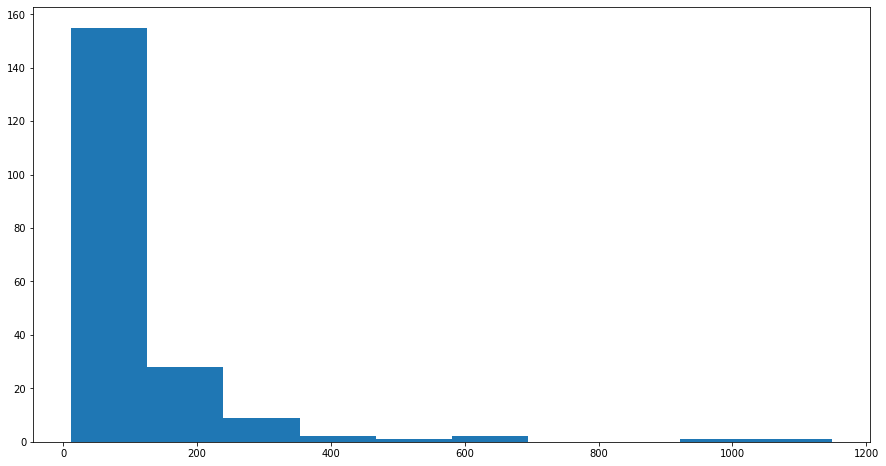

In [18]:
# get an idea of solar system sizes

size_unique = group.apply(lambda x: x['size_kwdc'].unique()[0])
plt.hist(size_unique)

Next, observe contract sizes: the histogram below is heavily skewed left w/ many small contracts and a few big ones.

(array([ 4., 17., 18.,  9., 36.,  5., 10.,  7., 26.,  3., 10., 54.]),
 array([ 1.        ,  1.91666667,  2.83333333,  3.75      ,  4.66666667,
         5.58333333,  6.5       ,  7.41666667,  8.33333333,  9.25      ,
        10.16666667, 11.08333333, 12.        ]),
 <a list of 12 Patch objects>)

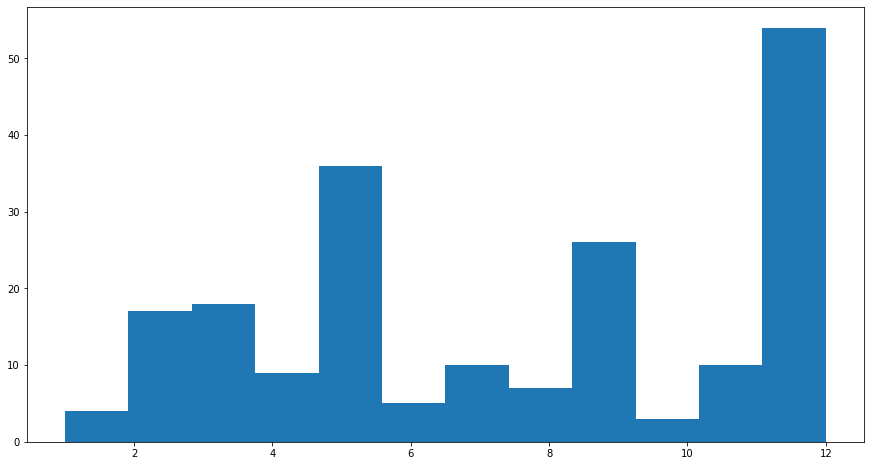

In [19]:
# plot how many systems have been opened each month (total) - to get an idea of monthly trends

month_unique = group.apply(lambda x: x['ato_date'].dt.month.unique()[0])
plt.hist(month_unique, bins = 12)

We also plot a histogram of ato dates to see if there is a trend in the month a solar system tends to be created. As we can see, most are created in December as companies rush to meet year-end quotas, and not many are opened in January following. The peak in May is likely due to an influx of new contracts this year, May 2021, with our data for 2021 only leading up to mid-June.

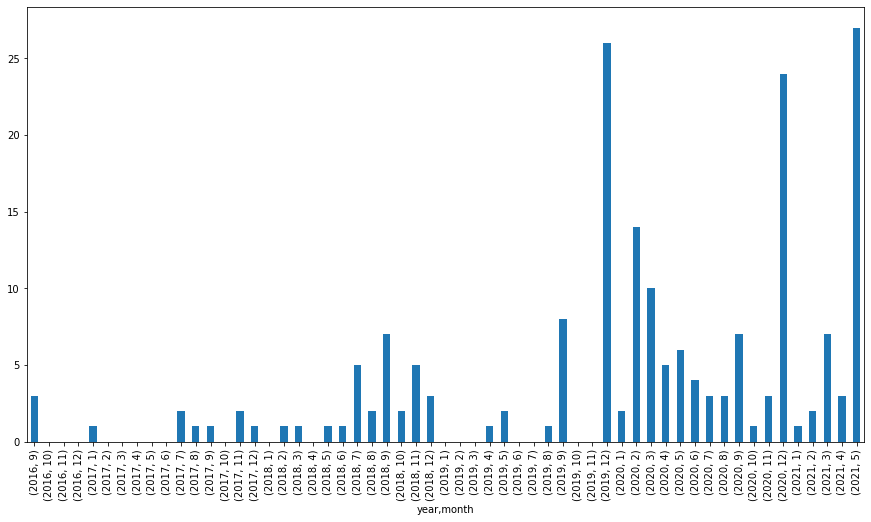

In [20]:
# plot how many systems were opened each month since Sep 2016

date_unique = pd.DataFrame() # new dataframe to store data by ato year and month
date_unique['year'] = group.apply(lambda x: x['ato_date'].dt.year.unique()[0]) # columns for year
date_unique['month'] = group.apply(lambda x: x['ato_date'].dt.month.unique()[0]) # and month
date_unique['count'] = 1 # count to keep track
agegroups = date_unique.groupby([date_unique['year'], date_unique['month']]).count()['count'] # count occurrences

# for months with 0 occurences, still add them as indices with values/counts of 0 for the bar plot
year = 2016
month = 9
while year < 2021:
    try:
        agegroups[(year, month)]
        if month == 12: 
            year += 1
            month = 1
        else: month += 1
    except:
        agegroups[(year, month)] = 0
        if month == 12: 
            year += 1
            month = 1
        else: month += 1
agegroups.sort_index(inplace = True)

agegroups.plot(kind = 'bar', figsize = (15, 8))

Breaking down our ato plot by year as well, we can see that more systems tend to be created each year as the company grows. Systems tend to peak in December, as observed before, and drop significantly for January. The fact that we only have data from September of 2016 may have also inflated the number in the month-only histogram above, causing the peak there. Interestingly, there are some months where no systems are created. Others, very few. However, evident by the peaks, the company must have the capacity to produce new systems quite quickly, making the lows potentially concerning in terms of demand. The peak this May may be due to the big deal with Franklin Park Infrastructure closed earlier this year. Below shows a cumulative plot of total systems over time (as opposed to only new systems created).

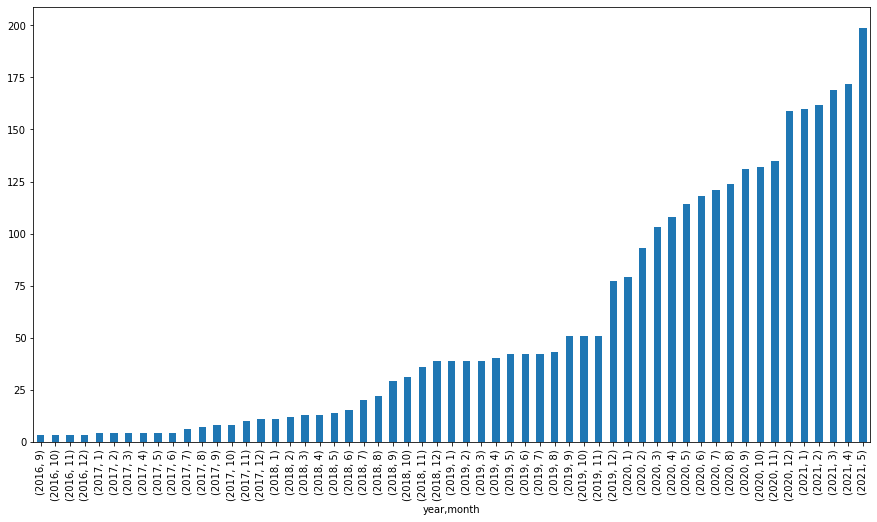

In [21]:
# cumulative number of systems since Sep 2016

agegroups.cumsum().plot(kind = 'bar', figsize = (15, 8))

Next, we will begin looking into production, a key variable of interest.

In [22]:
# get total production of each solar system

siteproduction = {contract: 0 for contract in set(union['contract_id'])} # create a dict to store values

# populate by summing production values for each contract id
for i in union.index:
    if np.isnan(union['actual_kwh'][i]): # skip nans
        continue
    siteproduction[union['contract_id'][i]] += union['actual_kwh'][i]

In [23]:
# avg production of each system (calculated by total production of a system divided by no. data points)
# may be inaccurate as no. data points don't always match no. production days (missing data)

avgsiteproduction = {}
# convert each contract's total production to avg by dividing by a count of datapoints per contract
for elem in siteproduction.keys():
    avgsiteproduction[elem] = siteproduction[elem] / union['contract_id'].value_counts()[elem]

(array([152.,  37.,   3.,   4.,   1.,   0.,   0.,   1.,   0.,   1.]),
 array([-108.45584904,  348.97916155,  806.41417213, 1263.84918272,
        1721.2841933 , 2178.71920389, 2636.15421447, 3093.58922506,
        3551.02423564, 4008.45924623, 4465.89425681]),
 <a list of 10 Patch objects>)

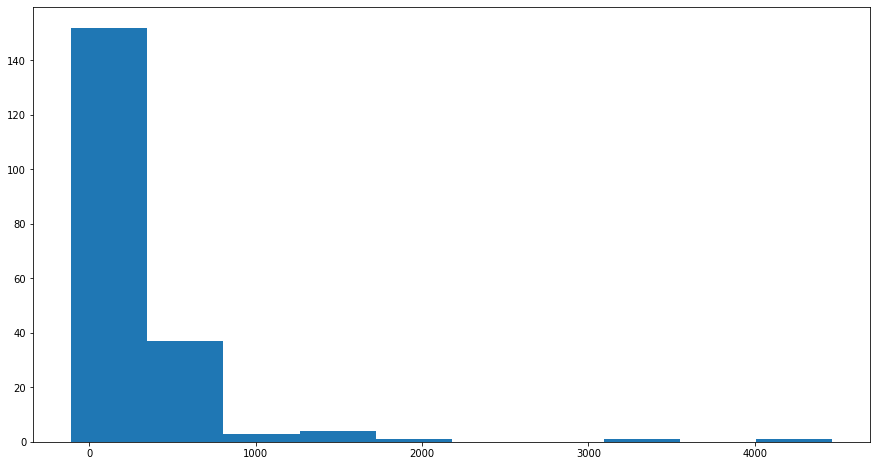

In [24]:
# plot histogram of average solar system production (skewed left w/ many smaller values and some large ones)

plt.hist(avgsiteproduction.values())

This plot of average system production looks very similar to the histogram of sizes from above - this makes sense. The plot is again heavily skewed left with a few systems producing very highly and most producing smaller amounts on average. Below, plotting size against production directly, we do see that the bigger systems have higher max production values compared to smaller ones. However, the variance is also higher. The trend is that production does increase with size, as we would expect. Some smaller contracts also occasionally produce really high power.

/Users/katherineli/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


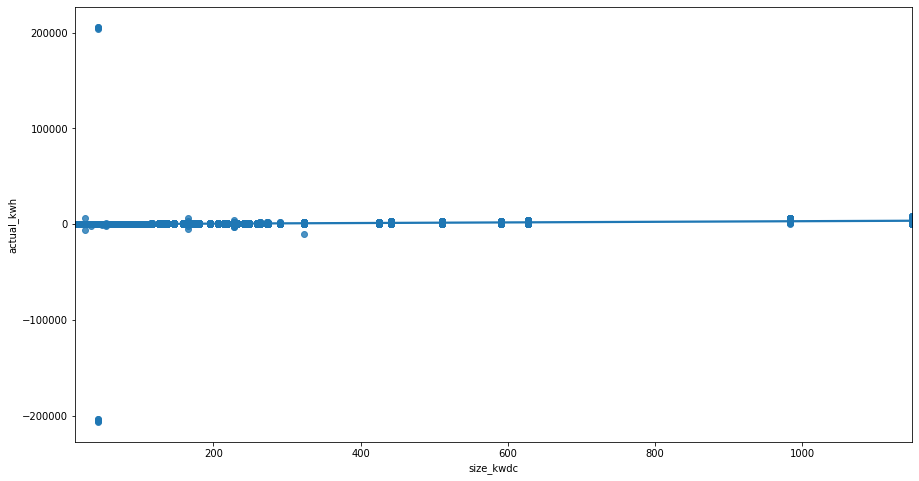

In [25]:
sns.regplot(union['size_kwdc'], union['actual_kwh'])

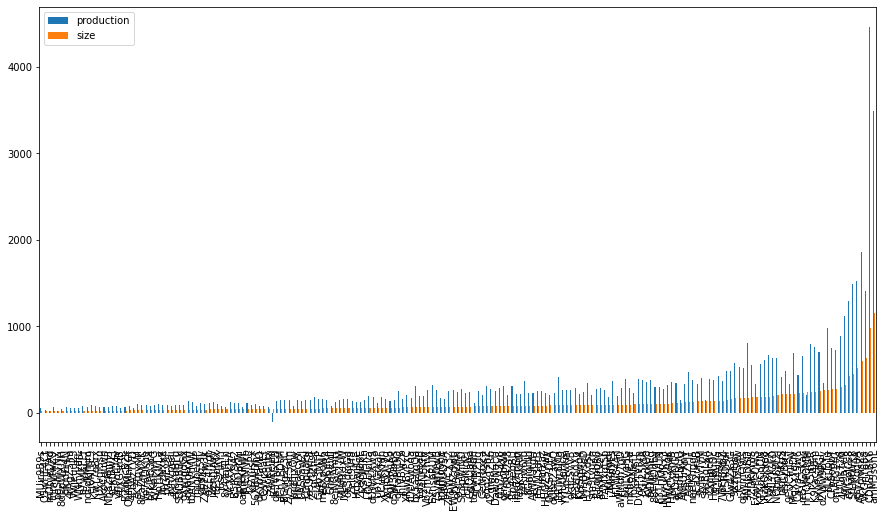

In [26]:
# plot each contract's size versus average (daily) production for comparison

size_production = pd.DataFrame() # combine to a new dataframe to plot using pandas
size_production['production'] = pd.Series(avgsiteproduction) # cast production dict as series and add column
size_production['size'] = size_unique # size is already a series from earlier, so just add it
size_production.sort_values(by = 'size').plot(kind = 'bar', figsize = (15, 8))

Plotted individually by contract (above), again, size corresponds with average production. Below, the ratios of production/size per system are also pretty randomly distributed, if not quite uniform. However, there is one contract with net negative production.

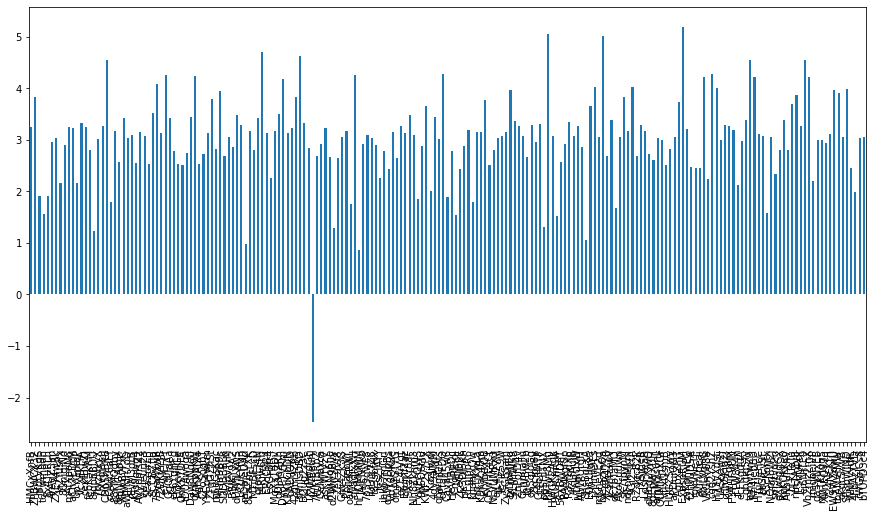

In [27]:
# find and plot ratios of production per size

size_production['ratio'] = pd.Series(avgsiteproduction)/size_unique # new column to dataframe for ratio
size_production['ratio'].plot(kind = 'bar', figsize = (15, 8))

In [28]:
print(min(size_production['ratio'].items(), key = lambda item: item[1])) # what's the one super negative value?
print(size_production['ratio'].mean()) # and average multiplier

('jZWEeuhJ', -2.4693954698324)
3.012499307274907


In [29]:
# examine the anomalous contract w/ net negative production

jZWEeuhJ = union[union['contract_id'] == 'jZWEeuhJ']
jZWEeuhJ[jZWEeuhJ['actual_kwh'] < 0] # filter for only negative production values - some EXTREMELY negative

,holding_company_id,project_company_id,contract_id,size_kwdc,created_on,updated_on,production_date,ato_date,actual_kwh,expected_kwh,...,host_type,revenue_type,interconnection_type,registry_facility_name,cref_short_name,subscriber_orginization,system_yield_as_built,system_yield_finance,annual_degradation_engr,annual_degradation_finance
43803,21,57,jZWEeuhJ,43.92,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2020-10-01,2018-07-10,-203217.536090,150.976558,...,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
44315,21,57,jZWEeuhJ,43.92,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2020-10-05,2018-07-10,-203769.953827,150.976558,...,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
44443,21,57,jZWEeuhJ,43.92,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2020-10-06,2018-07-10,-59.278923,150.976558,...,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
44571,21,57,jZWEeuhJ,43.92,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2020-10-07,2018-07-10,-147.025910,150.976558,...,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
44699,21,57,jZWEeuhJ,43.92,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2020-10-08,2018-07-10,-155.335679,150.976558,...,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
45339,21,57,jZWEeuhJ,43.92,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2020-10-13,2018-07-10,-205248.635567,150.976558,...,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
45594,21,57,jZWEeuhJ,43.92,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2020-10-15,2018-07-10,-205792.877759,150.976558,...,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
45721,21,57,jZWEeuhJ,43.92,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2020-10-16,2018-07-10,-38.183055,150.976558,...,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
46105,21,57,jZWEeuhJ,43.92,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2020-10-19,2018-07-10,-206639.162217,150.976558,...,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
60484,21,57,jZWEeuhJ,43.92,2021-02-01 19:02:01.052885,2021-04-06 21:20:57.800105,2021-01-31,2018-07-10,-0.142861,85.334577,...,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN


Looking further into the contract with negative production, we see, in fact, some VERY extreme negative values. We should probably check if there are more extreme values in the dataset and, if so, delete them so they don't skew our data.

In [30]:
# find all datapoints with actual production values less than -10 (concerning - for further inspection)

anomalies = {}

for i in union.index:
    if data['actual_kwh'][i] < -10:
        try:
            anomalies[data['contract_id'][i]].append((data['production_date'][i], data['actual_kwh'][i]))
        except:
            anomalies[data['contract_id'][i]] = [(data['production_date'][i], data['actual_kwh'][i])]
            
for elem in anomalies.keys():
    print(elem)
    for val in anomalies[elem]:
        print(val)

ek6YqHFq
('2019-01-06 00:00:00.000000', -41.99239388888888)
('2019-01-08 00:00:00.000000', -17.999270833333327)
('2019-01-10 00:00:00.000000', -48.036115555555526)
('2019-01-11 00:00:00.000000', -47.59431694444445)
('2019-01-16 00:00:00.000000', -16.59812055555554)
('2019-01-20 00:00:00.000000', -10.091960277777758)
('2019-01-21 00:00:00.000000', -24.332235)
('2019-01-22 00:00:00.000000', -21.9092675)
8EaZmYXK
('2019-04-25 00:00:00.000000', -5968.855)
ZXE74w3k
('2020-02-07 00:00:00.000000', -2172.002206388889)
gXwfgdGx
('2020-03-12 00:00:00.000000', -15.073318611102875)
('2020-03-13 00:00:00.000000', -32.14882166669122)
('2020-03-14 00:00:00.000000', -36.57348999999522)
('2020-03-15 00:00:00.000000', -15.886510555559653)
('2020-03-16 00:00:00.000000', -36.97634694444423)
('2020-03-17 00:00:00.000000', -32.73582027776865)
('2020-03-18 00:00:00.000000', -34.6662927777943)
('2020-03-19 00:00:00.000000', -18.1433272222057)
jZWEeuhJ
('2020-10-01 00:00:00.000000', -203217.53609)
('2020-10-05

In [31]:
union.drop(union[union['actual_kwh'] < -10].index, inplace = True)
union.drop(union[union['actual_kwh'] > 100000].index, inplace = True)

group = union.groupby('contract_id') # re-group for deletion

The plots below also show the clear relationship between size and production and lack thereof between either and ratio.

In [32]:
np.mean(size_production['ratio'])

3.012499307274907

In [33]:
1423/(365)

3.8986301369863012

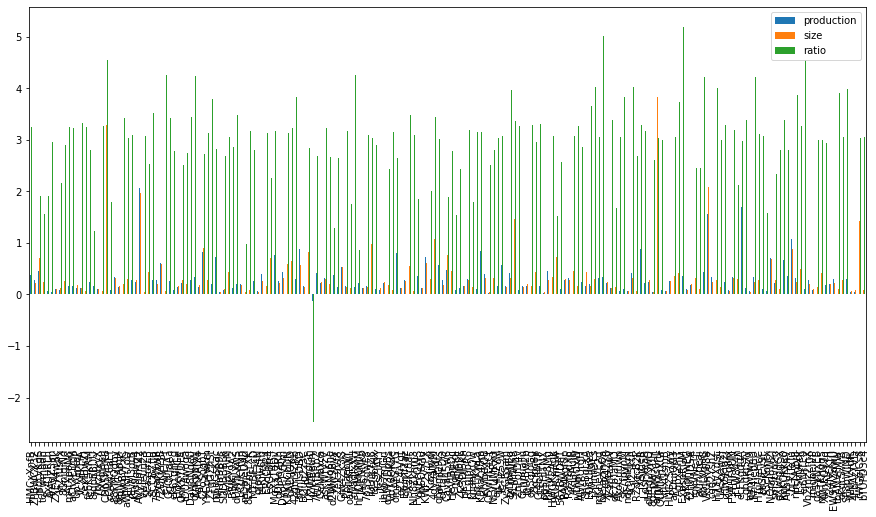

In [34]:
size_production['production'] = size_production['production']/900
size_production['size'] = size_production['size']/300
size_production['ratio'] = pd.Series(avgsiteproduction)/size_unique 

size_production.plot(kind = 'bar', figsize = (15, 8))

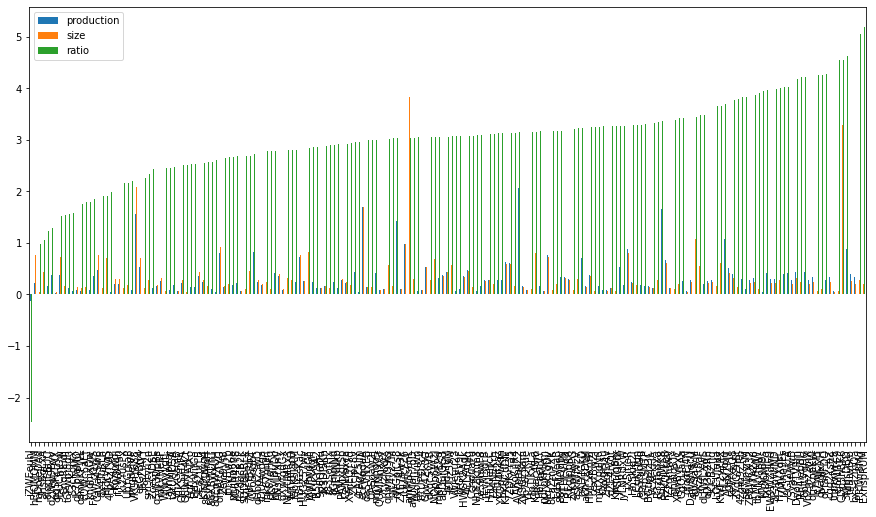

In [35]:
size_production.sort_values(by = 'ratio').plot(kind = 'bar', figsize = (15, 8))

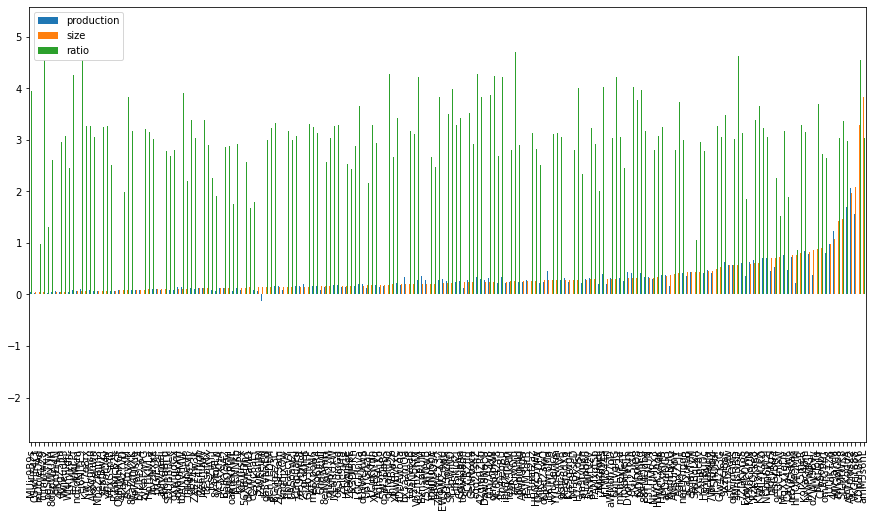

In [36]:
size_production.sort_values(by = 'size').plot(kind = 'bar', figsize = (15, 8))

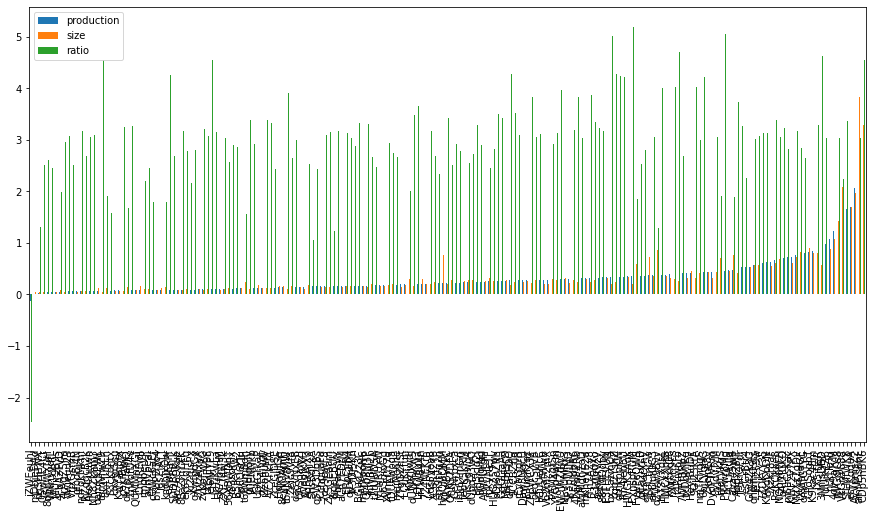

In [37]:
size_production.sort_values(by = 'production').plot(kind = 'bar', figsize = (15, 8))

We also want to check discrepancies between creation and last update to ensure our data is valid and look for potential non-comms. 

# wasn't the metric for 'problematic' 2 days??

In [38]:
# next, find datapoints with a lag between creation and last update (may be a sign of non-comms)

discrepancies = {}
for i in union.index:
    discrepancies[i] = union['updated_on'][i] - union['created_on'][i]

In [39]:
# create a new column in our data for discrepancies - flag any longer than 7 days (most of them???)

union['discrepancy'] = discrepancies.values()
union[union['discrepancy'] > pd.Timedelta('7 days')][['created_on', 'updated_on', 'discrepancy']]

,created_on,updated_on,discrepancy
38,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,27 days 06:38:04.281744
39,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,27 days 06:38:04.281744
41,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,27 days 06:38:04.281744
42,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,27 days 06:38:04.281744
43,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,27 days 06:38:04.281744
...,...,...,...
82810,2021-06-11 05:14:53.816845,2021-06-18 05:17:52.986922,7 days 00:02:59.170077
82811,2021-06-11 05:14:53.816845,2021-06-18 05:17:52.986922,7 days 00:02:59.170077
82813,2021-06-11 05:14:53.816845,2021-06-18 05:17:52.986922,7 days 00:02:59.170077
82814,2021-06-11 05:14:53.816845,2021-06-18 05:17:52.986922,7 days 00:02:59.170077


In [40]:
union['discrepancy'].dt.days.value_counts()

27.0     49919
66.0      5775
35.0      2482
64.0      1991
0.0       1690
         ...  
117.0      124
116.0      124
114.0      124
113.0      124
115.0      124
Name: discrepancy, Length: 86, dtype: int64

We also want to plot production as a function of time. The first plot below shows total production of all systems over time (including / not factoring out the growing number of systems), the second shows average production each month since the beginning of 2019, when we started collecting data, and the final plot shows average monthly production irrespective of year. As we would expect, these graphs all fluctuate with seasons, peaking in summer with more sunlight exposure and dropping in winter with less.

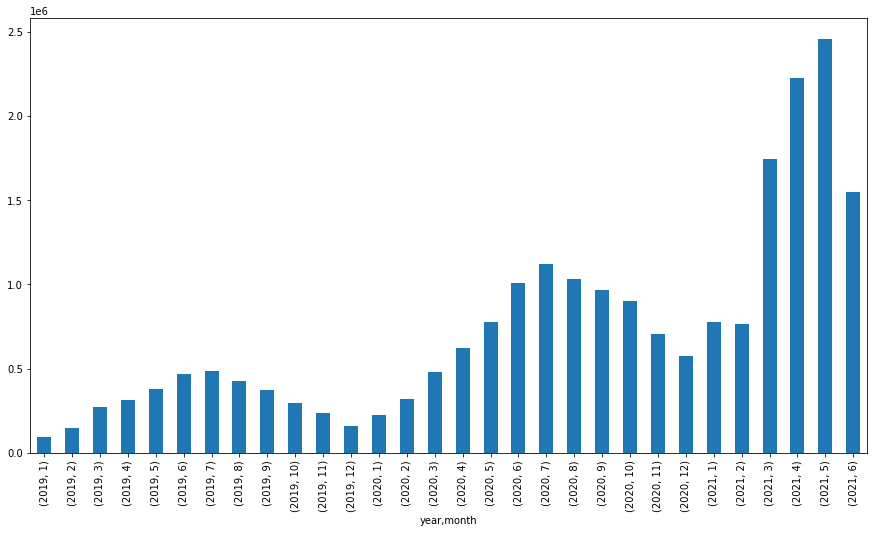

In [41]:
# plot total solar energy production as a function of time

production_date = pd.DataFrame()
production_date['year'] = group.apply(lambda x: x['production_date'].dt.year)
production_date['month'] = group.apply(lambda x: x['production_date'].dt.month)
production_date['production'] = group.apply(lambda x: x['actual_kwh'])
productiongroups = production_date.groupby([production_date['year'], production_date['month']])

productiongroups.sum()['production'].plot(kind = 'bar', figsize = (15, 8))

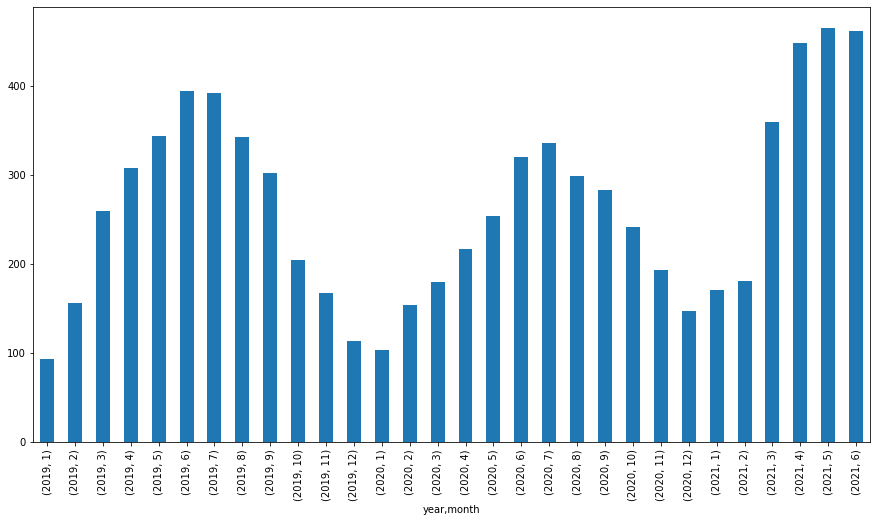

In [42]:
# average energy production per contract as a function of time - cyclic with seasons

productiongroups.mean()['production'].plot(kind = 'bar', figsize = (15, 8))

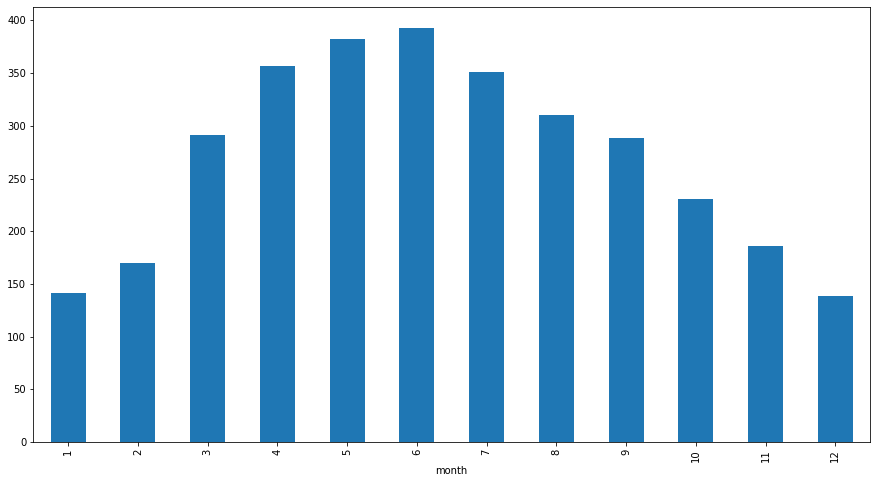

In [43]:
# average production per month disregarding year

productionmonth = production_date.groupby(production_date['month'])
productionmonth.mean()['production'].plot(kind = 'bar', figsize = (15, 8))

Next, we'll also plot production by ato dates. In the initial graph, it does seem like production by systems created this year is slightly higher than those from other years, but this could be due to chance, and it's generally pretty uniform over time. In the next graph by month only, there seems to be slightly lower production during later months compared to earlier ones, but again, it doesn't look like a big difference, and the graph is generally pretty uniform, meaning no real difference in production quality between months or years.

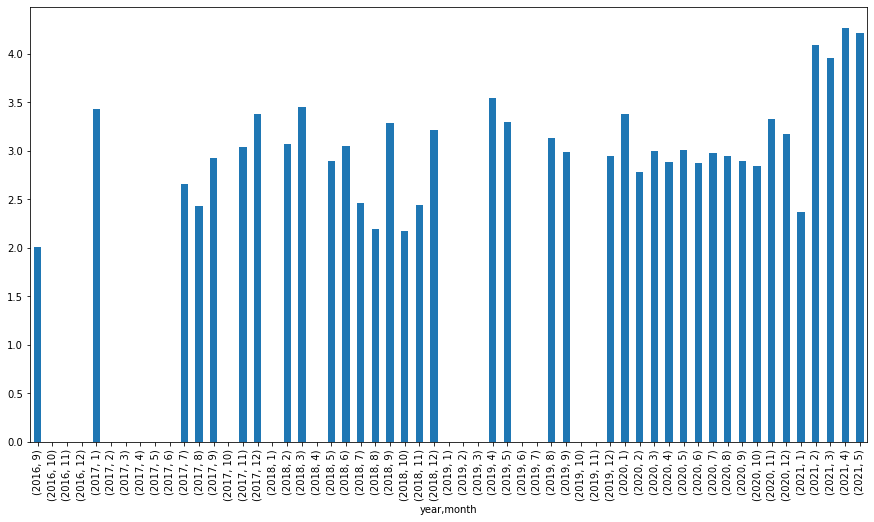

In [44]:
# plot average production of systems opened in each month since Sep 2016

ato_date = pd.DataFrame()
ato_date['year'] = group.apply(lambda x: x['ato_date'].dt.year)
ato_date['month'] = group.apply(lambda x: x['ato_date'].dt.month)
ato_date['production'] = group.apply(lambda x: x['actual_kwh'])
ato_date['ratio'] = group.apply(lambda x: x['actual_kwh']/x['size_kwdc'])
atogroups = ato_date.groupby([ato_date['year'], ato_date['month']])
atoplot = atogroups.mean()['ratio']

year = 2016
month = 9
while year < 2021:
    try:
        atoplot[(year, month)]
        if month == 12: 
            year += 1
            month = 1
        else: month += 1
    except:
        atoplot[(year, month)] = 0
        if month == 12: 
            year += 1
            month = 1
        else: month += 1
atoplot.sort_index(inplace = True)

atoplot.plot(kind = 'bar', figsize = (15, 8))

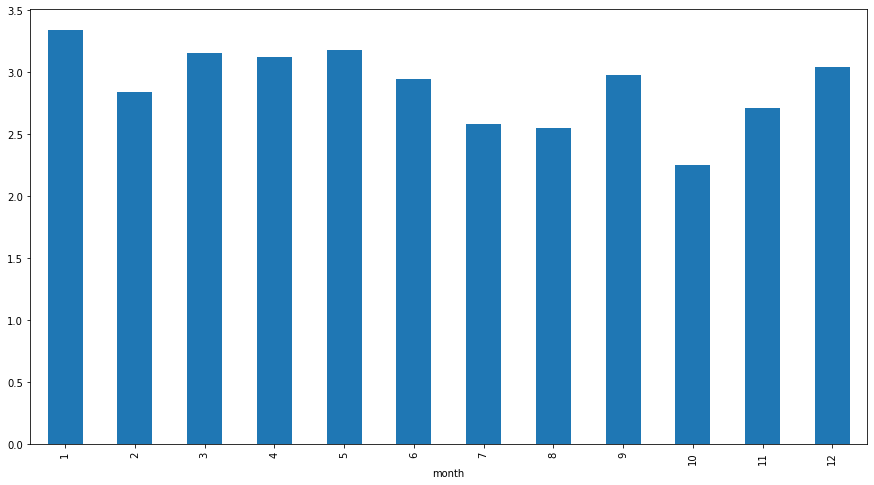

In [45]:
# average production of systems opened each month since Sep 2016 (by ato date) disregarding year

atomonth = ato_date.groupby(ato_date['month'])
atomonth.mean()['ratio'].plot(kind = 'bar', figsize = (15, 8))

We also might be interested in production over time. It's not very practical to generate a new graph for every contract (though it may be useful to do it for specific randomly chosen / bigger contracts), so we'll just assign each contract an age and plot age against production to track potential degradation.

In [46]:
# add a column to dataframe for age

union['system age'] = union.apply(lambda x: system_age[x['contract_id']].days, axis=1)

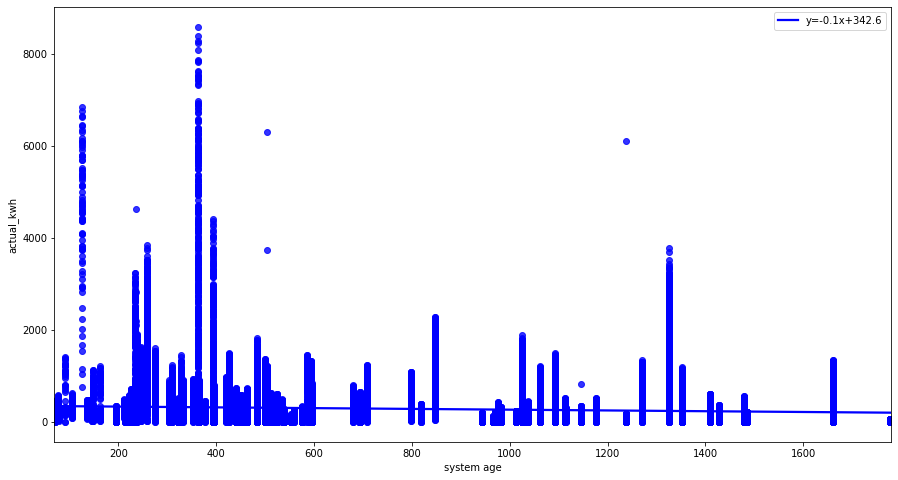

In [48]:
# scatterplot of age vs production

#sns.regplot(union['age'], union['actual_kwh'])

from scipy import stats

degradation = union[['system age', 'actual_kwh']].dropna()

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(degradation['system age'], degradation['actual_kwh'])

# use line_kws to set line label for legend
ax = sns.regplot(x = 'system age', y = 'actual_kwh', data = degradation, color='b', \
                 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})

# plot legend
ax.legend()

plt.show()

In [49]:
print(slope) # very naive calculation of degradation in units of kwh/day

-0.08369127910486374


In [50]:
dpy = slope*365 # degradation per year
dpy

-30.547316873275264

In [51]:
ppy = np.mean(union['actual_kwh'].dropna())*365 # average production per year
ppy

101125.25846395444

In [52]:
dpy/ppy

-0.0003020740548629964

In [53]:
union['annual_degradation_engr'].value_counts()

0.005    80531
Name: annual_degradation_engr, dtype: int64

In [54]:
ppy*0.005

505.6262923197722

In [136]:
union['ages'] = (union['production_date'] - union['in_service_date']).dt.days

In [137]:
union.head()

,holding_company_id,project_company_id,contract_id,size_kwdc,created_on,updated_on,production_date,ato_date,actual_kwh,expected_kwh,...,registry_facility_name,cref_short_name,subscriber_orginization,system_yield_as_built,system_yield_finance,annual_degradation_engr,annual_degradation_finance,discrepancy,system age,ages
0,15,44,4FbAzTVD,25.13,2021-02-24 03:49:53.575,2021-02-24 03:53:14.940699,2019-01-01,2018-11-29,NaN,42.908097,...,NON241648,NaN,NaN,1131.0,1131.0,0.005,NaN,0 days 00:03:21.365699,973,28.0
1,14,50,56XBWDhT,40.00,2021-02-24 03:49:53.575,2021-02-24 03:53:14.940699,2019-01-01,2018-09-28,NaN,71.340590,...,NON241695,NaN,NaN,954.7,1170.0,0.005,0.005,0 days 00:03:21.365699,1035,241.0
3,14,43,8EaZmYXK,26.18,2021-02-24 03:49:53.575,2021-02-24 03:53:14.940699,2019-01-01,2018-03-10,23.113000,50.342822,...,NON241367,NCS07,Arcadia,1240.8,1327.0,0.005,NaN,0 days 00:03:21.365699,1237,NaN
4,15,44,8GniqiNd,77.52,2021-02-24 03:49:53.575,2021-02-24 03:53:14.940699,2019-01-01,2018-07-12,NaN,142.074655,...,NON241708,NaN,NaN,1214.0,1214.0,0.005,NaN,0 days 00:03:21.365699,1113,NaN
5,3,6,B5JKY9A2,36.85,2021-02-24 03:49:53.575,2021-02-24 03:53:14.940699,2019-01-01,2018-12-02,32.874202,70.040201,...,NON228081,NaN,NaN,1259.0,1259.0,0.005,NaN,0 days 00:03:21.365699,970,NaN


In [141]:
union.groupby('contract_id').apply(lambda x: x['in_service_date']).dropna().index.get_level_values(0).unique()

Index(['4CLfAuJq', '4FbAzTVD', '4rAgZ5Jm', '56XBWDhT', '724NEKrh', '7ZDKyY35',
       '7tyzNxyX', '88FMQdby', '8dEpWXUH', '8ejNGAmH', '9p6Q6tTu', '9yJdvTyM',
       'AJWPUtgH', 'AkoCuuwn', 'CPoSogbT', 'ETumf2az', 'F3THFVUN', 'HTuUeHcC',
       'HUGZ57wv', 'HdxwiJGe', 'HpTiKwLa', 'JAjENNkb', 'JeTiz59w', 'KPKdCoDN',
       'KTs9gwg4', 'KwY7q8rx', 'LCuKYfun', 'LdsFVeaB', 'Nh8Zkhm3', 'PAMxgfSp',
       'QUMMnXGf', 'RzKQkke8', 'S3cKontx', 'SDDBBBLk', 'SfLMfWK8', 'ShsBqLxA',
       'UASoaw2J', 'Uxvgi5su', 'VcXFkFiA', 'VfjxGsmB', 'XRwBvPxC', 'Zeic9Vf8',
       'ZnPofD4v', 'askWfVzV', 'btGiEv9F', 'cQWc6aEf', 'cexfBwZJ', 'd2Ww9Bvv',
       'dk7bTaMQ', 'ek6YqHFq', 'gXwfgdGx', 'ghdiq5Ty', 'hFjQMQMM', 'ihk67mGn',
       'jZznhuwV', 'kndhjxQw', 'mujNo6he', 'nmTKhgg5', 'oALYJGkD', 'oamkKPWL',
       'qfodEj4N', 'rmqbeiVP', 'tbANVfMW', 'zvKpFwPG'],
      dtype='object', name='contract_id')

In [134]:
degradations = {}

for contract in contracts.index:
    df = union[union['contract_id'] == contract][['ages', 'actual_kwh']].dropna()
    if not df.empty:
        degradations[contract] = stats.linregress(df['ages'], df['actual_kwh'])

print(degradations)

ValueError: Could not convert object to NumPy timedelta

In [100]:
annual_degradation = {}
for elem in degradations.items():
    annual_degradation[elem[0]] = elem[1][0]/(group.mean()['actual_kwh'][elem[0]])

In [106]:
np.mean(np.abs(list(annual_degradation.values())))

0.0011181499074123732

In [113]:
len(annual_degradation.keys())

64

In [112]:
union['degradation'] = union.apply(lambda row: annual_degradation[row.contract_id], axis=1)

KeyError: '8EaZmYXK'

Next, we'll create some new columns which could be useful for modeling or perhaps further analysis.

In [142]:
union['production_year'] = union['production_date'].dt.year
pyear = pd.get_dummies(union['production_year'])
pyear.columns = ["prod" + str(name) for name in pyear]
union['production_month'] = union['production_date'].dt.month
pmonth = pd.get_dummies(union['production_month'])
pmonth.columns = ["prod" + str(name) for name in pmonth]
union['ato_year'] = union['ato_date'].dt.year
atoyear = pd.get_dummies(union['ato_year'])
atoyear.columns = ["ato" + str(name) for name in atoyear]
union['ato_month'] = union['ato_date'].dt.month
atomonth = pd.get_dummies(union['ato_month'])
atomonth.columns = ["ato" + str(name) for name in atomonth]
union = pd.concat([union, pyear, pmonth, atoyear, atomonth], axis = 1)

In [143]:
holding_ids = pd.get_dummies(union['holding_company_id'])
holding_ids.columns = ["h" + str(name) for name in holding_ids]
project_ids = pd.get_dummies(union['project_company_id'])
project_ids.columns = ["p" + str(name) for name in project_ids]
union = pd.concat([union, holding_ids, project_ids], axis = 1)
union['holding_company_id'] = union['holding_company_id'].astype('category')
union['project_company_id'] = union['project_company_id'].astype('category')

/Users/katherineli/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


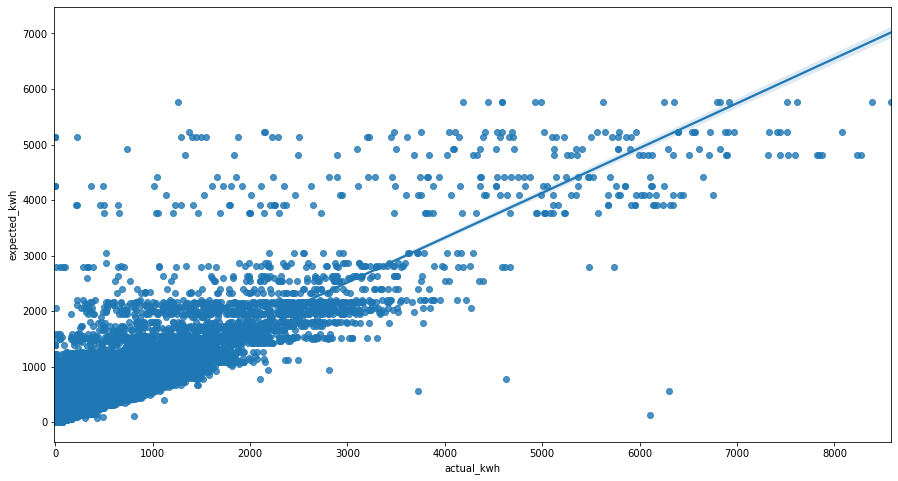

In [144]:
subset = union[['actual_kwh', 'expected_kwh']].copy()
sns.regplot(subset['actual_kwh'], subset['expected_kwh'])

In [145]:
union['yield'] = union['actual_kwh']/union['size_kwdc']
union['efficiency'] = union['actual_kwh']/union['expected_kwh']

In [146]:
# flag contracts with low production

union[union['efficiency'] < 0.1].groupby('contract_id').apply(lambda x: x['production_date'])

contract_id       
4CLfAuJq     47321   2020-10-29
             53534   2020-12-16
             60402   2021-01-31
             60559   2021-02-01
             60720   2021-02-02
                        ...    
zvKpFwPG     53665   2020-12-16
             60556   2021-01-31
             60717   2021-02-01
             60878   2021-02-02
             63472   2021-02-18
Name: production_date, Length: 6066, dtype: datetime64[ns]

In [147]:
# potential loss due to weather

union[union['expected_kwh'] < union['weather_adjusted_expected_kwh']]

,holding_company_id,project_company_id,contract_id,size_kwdc,created_on,updated_on,production_date,ato_date,actual_kwh,expected_kwh,...,p81,p82,p83,p84,p85,p86,p87,p88,yield,efficiency
29313,15,44,4FbAzTVD,25.13,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2020-06-01,2018-11-29,NaN,109.349023,...,0,0,0,0,0,0,0,0,NaN,NaN
29314,4,8,4qv9aTyM,322.90,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2020-06-01,2019-04-03,2179.220000,1712.115132,...,0,0,0,0,0,0,0,0,6.748901,1.272823
29315,5,10,4rAgZ5Jm,17.28,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2020-06-01,2020-02-23,112.605611,86.247141,...,0,0,0,0,0,0,0,0,6.516528,1.305616
29316,14,50,56XBWDhT,40.00,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2020-06-01,2018-09-28,236.606000,177.181273,...,0,0,0,0,0,0,0,0,5.915150,1.335389
29318,15,44,724NEKrh,61.60,2021-01-27 21:15:10.658955,2021-02-24 03:53:14.940699,2020-06-01,2019-05-03,365.096697,291.452957,...,0,0,0,0,0,0,0,0,5.926894,1.252678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80611,8,62,ZnPofD4v,21.80,2021-05-31 06:23:18.863399,2021-06-18 05:17:52.986922,2021-05-31,2019-12-31,138.689224,89.782490,...,0,0,0,0,0,0,0,0,6.361891,1.544725
80612,30,77,ZTgGZhSt,46.10,2021-06-11 14:21:39.146341,2021-06-18 05:17:52.986922,2021-05-31,2021-02-17,246.198068,192.931496,...,0,0,0,0,0,0,0,0,5.340522,1.276091
80613,5,10,zvKpFwPG,28.80,2021-05-31 06:23:18.863399,2021-06-18 05:17:52.986922,2021-05-31,2020-03-12,148.275470,114.380061,...,0,0,0,0,0,0,0,0,5.148454,1.296340
80614,1,54,ZvSGESam,45.00,2021-05-31 06:23:18.863399,2021-06-18 05:17:52.986922,2021-05-31,2020-12-14,259.711088,188.600619,...,0,0,0,0,0,0,0,0,5.771358,1.377043


# 3. Modeling

In [148]:
from sklearn.metrics.pairwise import rbf_kernel # for modeling
from sklearn.linear_model import Ridge, LinearRegression # also for modeling
import statsmodels.api as statsmodels

In [149]:
correlations = union.corr()

In [150]:
heatmap = correlations.iloc[:10, :10].dropna(how = 'all')
heatmap.dropna(axis = 1, how = 'all', inplace = True)

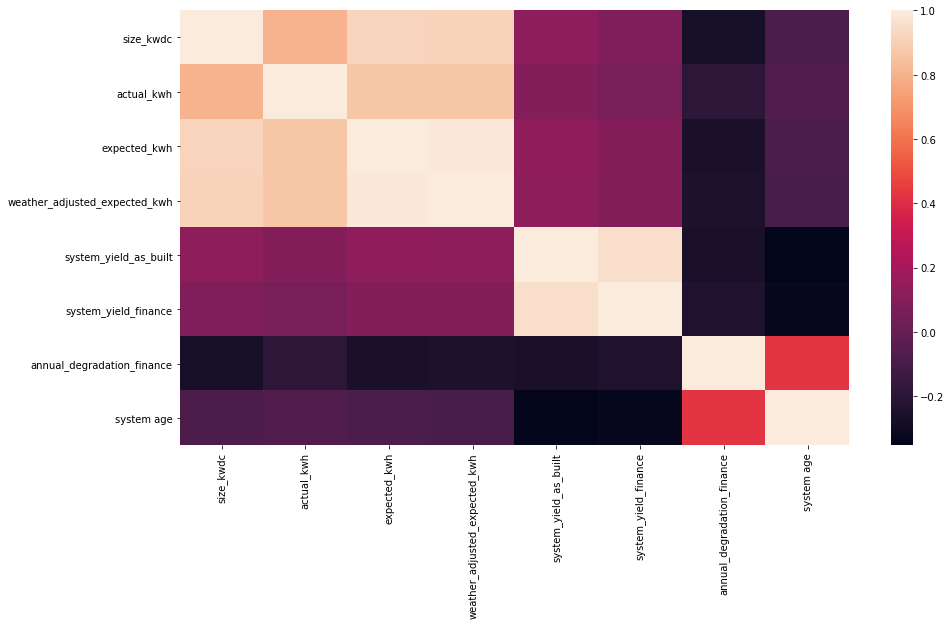

In [151]:
sns.heatmap(heatmap, xticklabels=heatmap.columns, yticklabels=heatmap.columns)

In [152]:
useful = dict()
for elem in correlations['actual_kwh'].items():
    if abs(elem[1]) > 0.1 and abs(elem[1]) != 1:
        useful[elem[0]] = elem[1]
sorted(useful.items(), key = lambda x: x[1])

[('annual_degradation_finance', -0.19344695758235758),
 ('ato2018', -0.13085332217758985),
 ('h5', -0.12318019884085395),
 ('p10', -0.12278134627175964),
 ('h8', -0.10886472097776372),
 ('h20', -0.10736639603571203),
 ('p56', -0.10721808885381087),
 ('h14', -0.10616527848924667),
 ('system_yield_as_built', 0.10085900037925506),
 ('h6', 0.10419689314716435),
 ('ato2020', 0.10724815676751415),
 ('p5', 0.10828378148073463),
 ('p2', 0.10917256290233149),
 ('p11', 0.10981872697056758),
 ('prod2021', 0.11378393084326828),
 ('ato4', 0.12254846525223835),
 ('ato2017', 0.13247834580152368),
 ('h3', 0.1501928657170406),
 ('p6', 0.15040918977126153),
 ('p3', 0.17914743737192831),
 ('h4', 0.18141845897722972),
 ('p8', 0.18289670498744523),
 ('p4', 0.1890654122130893),
 ('h1', 0.21128103191002018),
 ('ages', 0.2981474399909804),
 ('efficiency', 0.3242290184989711),
 ('yield', 0.37250721455570013),
 ('p1', 0.4200279114259559),
 ('size_kwdc', 0.7998489754745244),
 ('expected_kwh', 0.865231675385602),

In [153]:
def mult_regression(df, column_x, column_y):
    ''' this function uses built in library functions to construct a linear 
    regression model with potentially multiple predictor variables. It outputs 
    two plots to assess the validity of the model.'''

    # If there is only one predictor variable, plot the regression line
    if len(column_x)==1:
        plt.figure()
        sns.regplot(x=column_x[0], y=column_y, data=df, marker="+",fit_reg=True,color='orange')

    # define predictors X and response Y:
    X = df[column_x]
    X = statsmodels.add_constant(X)
    Y = df[column_y]

    # construct model:
    global regressionmodel 
    regressionmodel = statsmodels.OLS(Y,X).fit() # OLS = "ordinary least squares"

    # residual plot:
    plt.figure()
    residualplot = sns.residplot(x=regressionmodel.predict(), y=regressionmodel.resid, color='green')
    residualplot.set(xlabel='Fitted values for '+column_y, ylabel='Residuals')
    residualplot.set_title('Residuals vs Fitted values',fontweight='bold',fontsize=14)

    # QQ plot:
    qqplot = statsmodels.qqplot(regressionmodel.resid,fit=True,line='45')
    qqplot.suptitle("Normal Probability (\"QQ\") Plot for Residuals",fontweight='bold',fontsize=14)

/Users/katherineli/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             actual_kwh   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.738e+31
Date:                Fri, 30 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:55:26   Log-Likelihood:                 12189.
No. Observations:                 443   AIC:                        -2.436e+04
Df Residuals:                     435   BIC:                        -2.433e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
size_kwdc                     -1.885e-13   8.95e-18  -2.11e+04      0.000   -1.89e-13   -1.88e-13
expected_kwh                  -5.676e-15   5.47e-16    -10.368      0.000   -6.75e-15    -4.6e-15
weather_adjusted_expected_kwh  3.303e-15   4.25e-16      7.769      0.000    2.47e-15    4.14e-15
system_yield_as_built          1.493e-14    1.2e-16    124.700      0.000    1.47e-14    1.52e-14
annual_degradation_finance    -2.209e-14   2.37e-22  -9.31e+07      0.000   -2.21e-14   -2.21e-14
ages                          -1.985e-15   2.27e-16     -8.760      0.000   -2.43e-15   -1.54e-15
prod2021                       1.199e-13    5.2e-14      2.306      0.022    1.77e-14    2.22e-13
ato2017                        3.022e-15   1.45e-29   2.08e+14      0.000    3.02e-15    3.02e-15
ato2018                                0          0        nan        nan           0           0
ato2020                       -5.895e-15   9.49e-20  -6.21e+04      0.000   -5.89e-15   -5.89e-15
ato4                                   0          0        nan        nan           0           0
h1                                     0          0        nan        nan           0           0
h3                                     0          0        nan        nan           0           0
h4                                     0          0        nan        nan           0           0
h5                                     0          0        nan        nan           0           0
h6                                     0          0        nan        nan           0           0
h8                            -1.688e-14   4.16e-14     -0.405      0.686   -9.87e-14     6.5e-14
h14                             9.77e-15   4.16e-14      0.235      0.815   -7.21e-14    9.16e-14
h20                                    0          0        nan        nan           0           0
p1                                     0          0        nan        nan           0           0
p2                                     0          0        nan        nan           0           0
p3                                     0          0        nan        nan           0           0
p4                                     0          0        nan        nan           0           0
p5                                     0          0        nan        nan           0           0
p6                                     0          0        nan        nan           0           0
p8                                     0          0        nan        nan           0           0
p10                                    0          0        nan        nan           0           0
p11                                    0          0        nan        nan           0           0
p56                                    0     

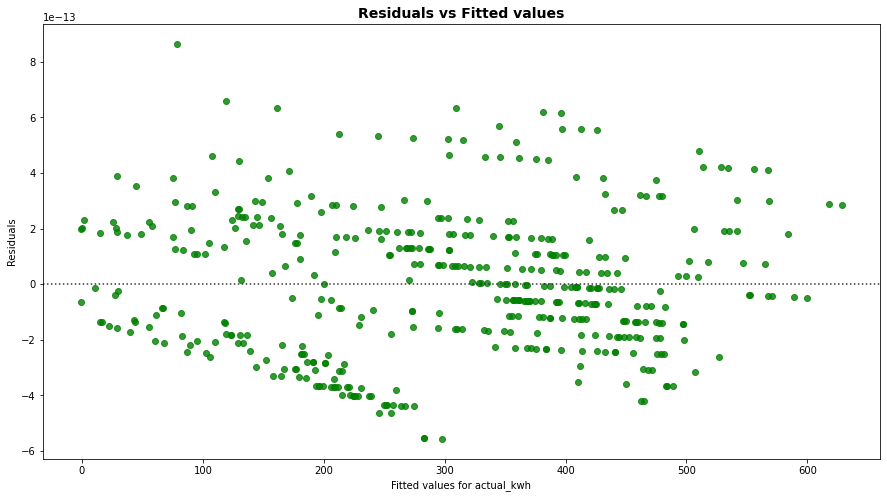

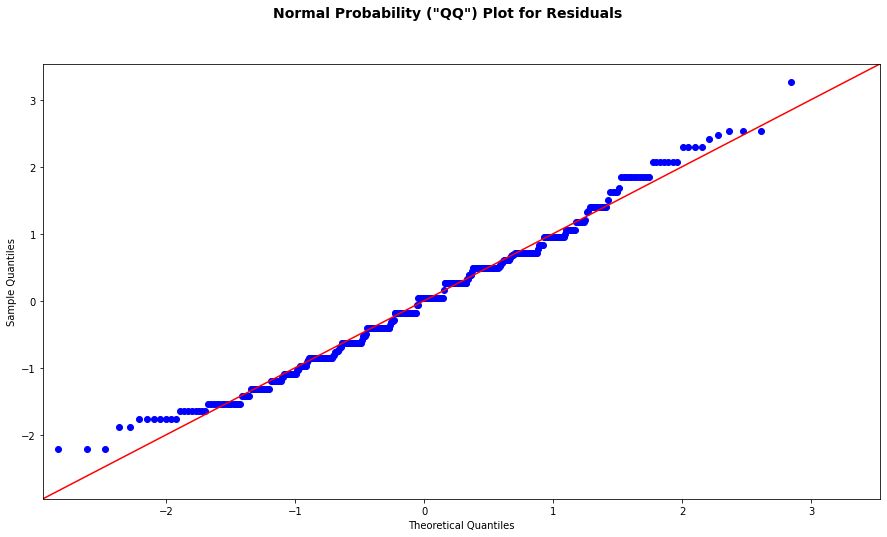

In [154]:
mult_regression(union.dropna(), list(useful.keys()), 'actual_kwh')
regressionmodel.summary()

In [155]:
union['production_days'] = union['production_date'].astype('int64')//1e9//60//60//24 % 365
union['ato_days'] = union['ato_date'].astype('int64')//1e9//60//60//24 % 365

/Users/katherineli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """Entry point for launching an IPython kernel.
/Users/katherineli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  


/Users/katherineli/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             actual_kwh   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.04346
Date:                Fri, 30 Jul 2021   Prob (F-statistic):              0.835
Time:                        15:55:26   Log-Likelihood:                -2829.8
No. Observations:                 443   AIC:                             5664.
Df Residuals:                     441   BIC:                             5672.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
size_kwdc                      1.9892      0.092     21.518      0.000       1.808       2.171
ato_days                       1.5606      0.073     21.518      0.000       1.418       1.703
annual_degradation_finance  5.272e-05   2.45e-06     21.518      0.000    4.79e-05    5.75e-05
production_days               -0.0147      0.070     -0.208      0.835      -0.153       0.124
==============================================================================
Omnibus:                       42.644   Durbin-Watson:                   0.813
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.076
Skew:                          -0.170   Prob(JB):                     0.000532
Kurtosis:                       2.162   Cond. No.                     7.80e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.77e-39. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

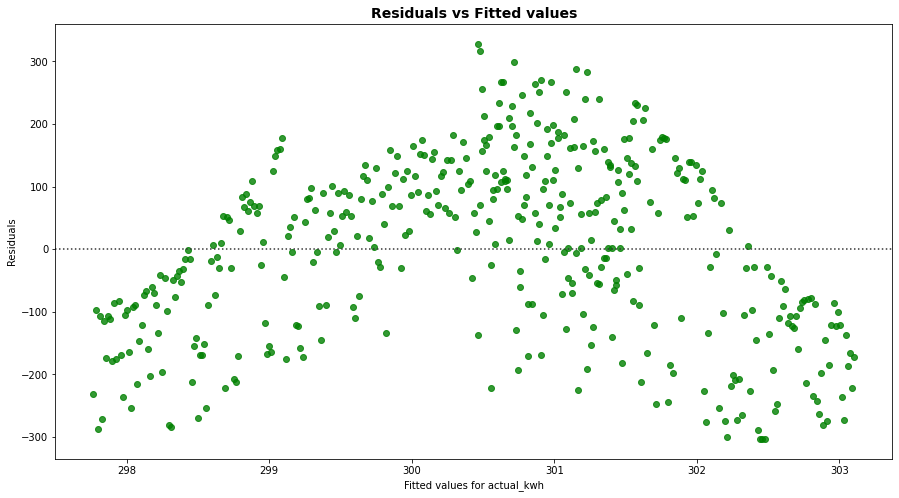

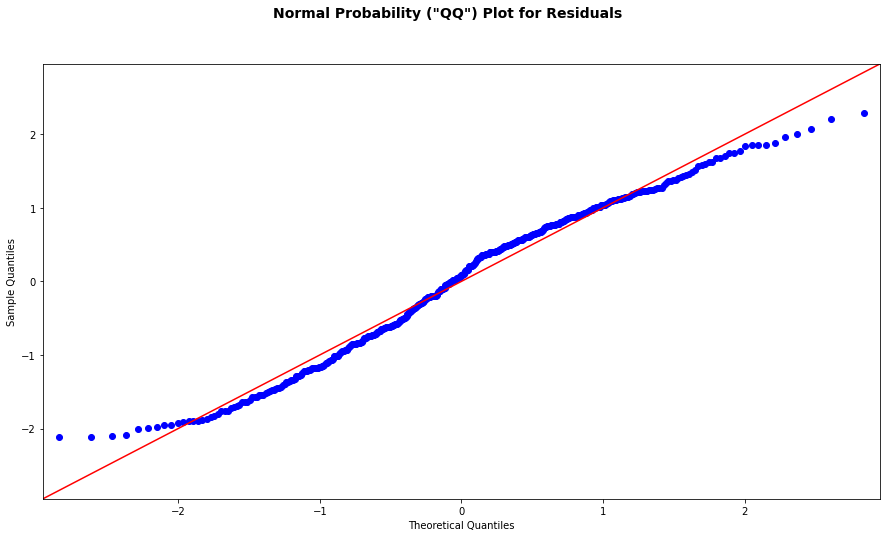

In [156]:
mult_regression(union.dropna(), ['size_kwdc', 'ato_days', 'annual_degradation_finance', 'production_days'], 'actual_kwh')
regressionmodel.summary()

In [157]:
predictors = dict()
for elem in correlations['efficiency'].items():
    if abs(elem[1]) > 0.1 and abs(elem[1]) != 1:
        predictors[elem[0]] = elem[1]
sorted(predictors.items(), key = lambda x: x[1])
list(predictors.keys())

['actual_kwh',
 'system_yield_finance',
 'ages',
 'production_year',
 'h20',
 'p56',
 'yield']

/Users/katherineli/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/katherineli/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             efficiency   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     6.954
Date:                Fri, 30 Jul 2021   Prob (F-statistic):            0.00106
Time:                        15:55:27   Log-Likelihood:                -152.94
No. Observations:                 443   AIC:                             311.9
Df Residuals:                     440   BIC:                             324.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
system_yield_finance     0.0998      0.094      1.060      0.290      -0.085       0.285
ages                     0.0007      0.000      2.825      0.005       0.000       0.001
production_year         -0.0653      0.062     -1.054      0.292      -0.187       0.056
h20                           0          0        nan        nan           0           0
==============================================================================
Omnibus:                       17.140   Durbin-Watson:                   1.442
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.845
Skew:                          -0.467   Prob(JB):                     0.000133
Kurtosis:                       2.695   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

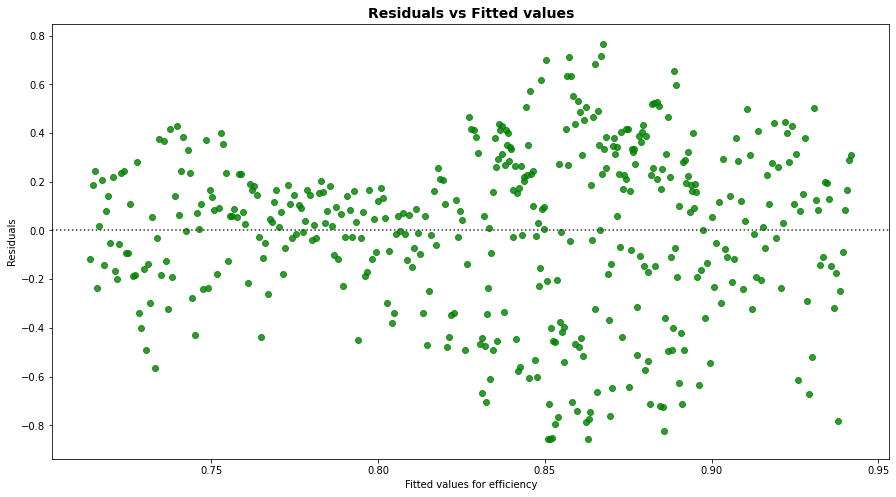

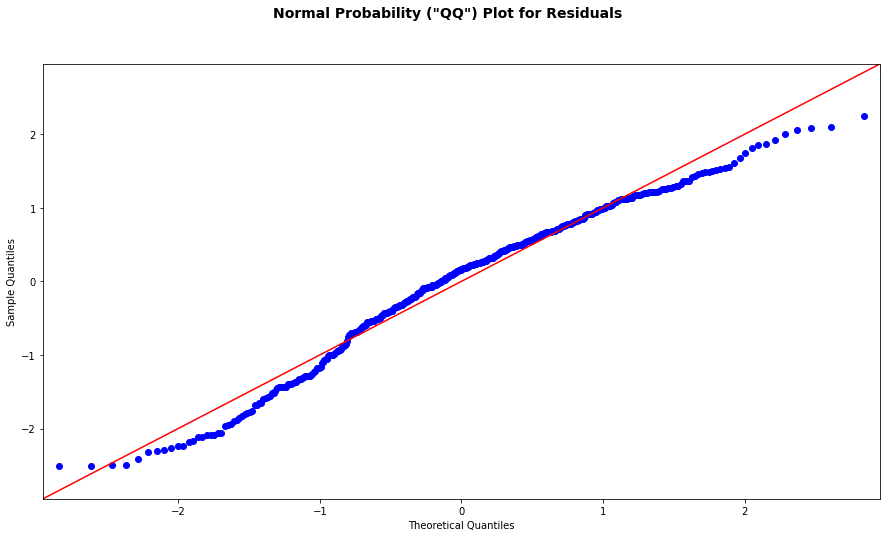

In [158]:
mult_regression(union.dropna(), list(predictors.keys())[1:5], 'efficiency')
regressionmodel.summary()

(array([ 9082.,  6952.,  7786.,  8912., 11947., 14628., 11130.,  4829.,
         1594.,  2172.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

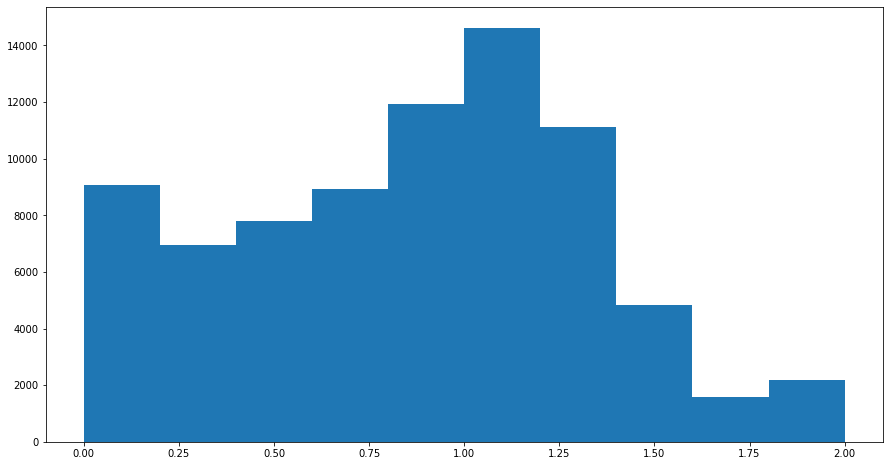

In [159]:
union.loc[union['efficiency'] > 2, 'efficiency'] = 2
union.loc[union['efficiency'] < 0, 'efficiency'] = 0

plt.hist(union['efficiency'])

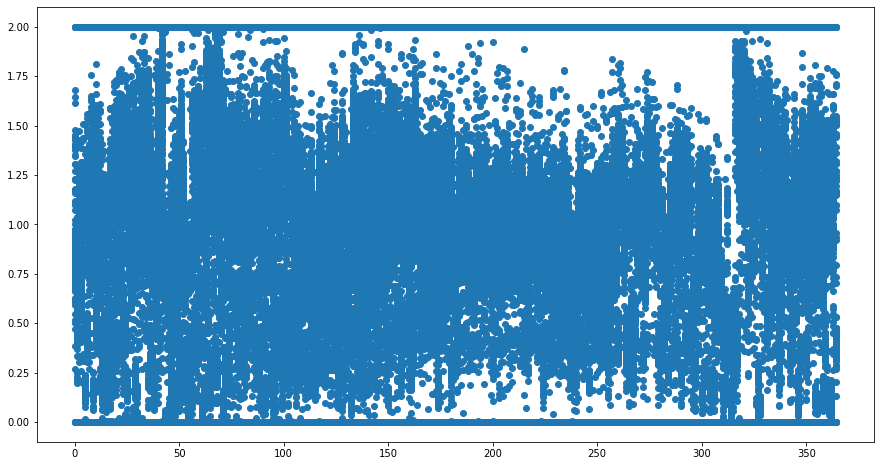

In [160]:
plt.scatter(union['production_days'], union['efficiency'])

In [161]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings('ignore')

from kats.consts import TimeSeriesData

forecast = TimeSeriesData(union[['production_date', 'actual_kwh']].dropna(), time_col_name = 'production_date')

In [162]:
forecast

,production_date,actual_kwh
0,2019-01-01,23.113000
1,2019-01-01,50.037000
2,2019-01-01,61.724000
3,2019-01-01,11.180000
4,2019-01-01,365.505569
...,...,...
79027,2021-06-17,457.427783
79028,2021-06-17,339.313609
79029,2021-06-17,214.989311
79030,2021-06-17,312.327829


In [163]:
# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(forecast, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=60, freq="MS")

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [164]:
fcst.head()

,time,fcst,fcst_lower,fcst_upper
0,2021-07-01,531.869526,-28.155802,1099.780153
1,2021-08-01,473.458536,-83.068196,1006.314991
2,2021-09-01,500.898949,-50.416283,1106.312422
3,2021-10-01,443.198514,-142.194589,1007.183692
4,2021-11-01,315.512701,-266.622891,879.092841


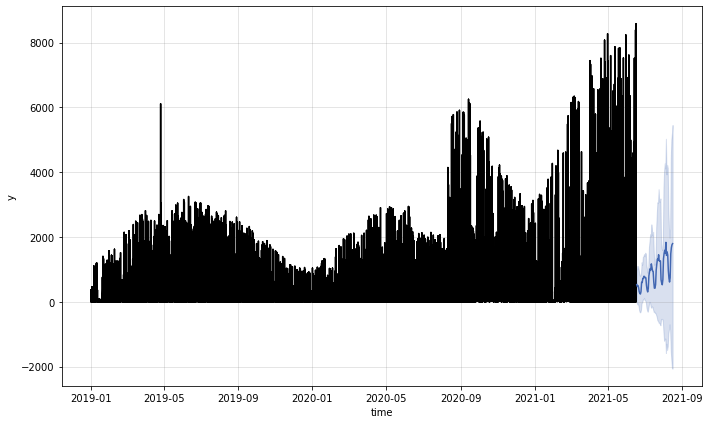

In [165]:
m.plot()

In [166]:
forecast2 = TimeSeriesData(union[['production_date', 'efficiency']], time_col_name = 'production_date')

m2 = ProphetModel(forecast2, params)

m2.fit()

# make prediction for next 30 month
fcst2 = m2.predict(steps=60, freq="MS")

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [167]:
fcst2.head()

,time,fcst,fcst_lower,fcst_upper
0,2021-07-01,0.944119,0.369626,1.487171
1,2021-08-01,0.798595,0.216477,1.388275
2,2021-09-01,0.759918,0.156217,1.365999
3,2021-10-01,0.694479,0.104862,1.276409
4,2021-11-01,0.627853,0.010838,1.249761


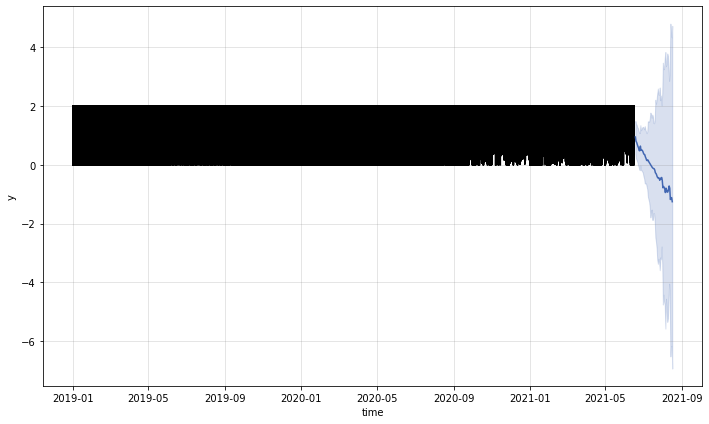

In [168]:
m2.plot()

In [169]:
noncomms = union[union['actual_kwh'].isnull()][['contract_id', 'production_date']].groupby('contract_id')

In [170]:
noncommdates = noncomms.apply(lambda x: x['production_date'])
noncommdates

contract_id       
3NnJsDBD     84016   2021-06-18
42gm9ZRb     84017   2021-06-18
4CLfAuJq     84018   2021-06-18
4FbAzTVD     0       2019-01-01
             38      2019-01-02
                        ...    
zvKpFwPG     50025   2020-11-18
             50154   2020-11-19
             50283   2020-11-20
             50412   2020-11-21
             84213   2021-06-18
Name: production_date, Length: 3030, dtype: datetime64[ns]

In [204]:
print('hello world')

hello world


In [171]:
noncommdict = {}
for elem in contracts.index:
    try:
        if len(noncommdates[elem]) > 1:
            noncommdict[elem] = list(noncommdates[elem])
    except:
        pass
sorted(noncommdict.items())

[('4FbAzTVD',
  [Timestamp('2019-01-01 00:00:00'),
   Timestamp('2019-01-02 00:00:00'),
   Timestamp('2019-01-03 00:00:00'),
   Timestamp('2019-01-04 00:00:00'),
   Timestamp('2019-01-05 00:00:00'),
   Timestamp('2019-01-06 00:00:00'),
   Timestamp('2019-01-07 00:00:00'),
   Timestamp('2019-01-08 00:00:00'),
   Timestamp('2019-01-09 00:00:00'),
   Timestamp('2019-01-10 00:00:00'),
   Timestamp('2019-01-11 00:00:00'),
   Timestamp('2019-01-12 00:00:00'),
   Timestamp('2019-01-13 00:00:00'),
   Timestamp('2019-01-14 00:00:00'),
   Timestamp('2019-01-15 00:00:00'),
   Timestamp('2019-01-16 00:00:00'),
   Timestamp('2019-01-17 00:00:00'),
   Timestamp('2019-01-18 00:00:00'),
   Timestamp('2019-01-19 00:00:00'),
   Timestamp('2019-01-20 00:00:00'),
   Timestamp('2019-01-21 00:00:00'),
   Timestamp('2019-01-22 00:00:00'),
   Timestamp('2019-01-23 00:00:00'),
   Timestamp('2019-01-24 00:00:00'),
   Timestamp('2019-01-25 00:00:00'),
   Timestamp('2019-01-26 00:00:00'),
   Timestamp('2019-01-27

In [201]:
totalnoncomms = {elem: len(noncommdict[elem]) for elem in noncommdict.keys()}

In [203]:
sorted(totalnoncomms.items(), key = lambda x: x[1])

[('nmTKhgg5', 3),
 ('SfLMfWK8', 3),
 ('JeTiz59w', 3),
 ('bTUPD3c4', 3),
 ('Vwjeuu23', 3),
 ('aWMdh7oD', 3),
 ('aPDuiQG3', 3),
 ('R3zf6dXo', 3),
 ('hfdtVKgS', 3),
 ('K9kac48m', 3),
 ('8EaZmYXK', 4),
 ('724NEKrh', 4),
 ('88FMQdby', 4),
 ('esGrBtr4', 4),
 ('NQpn6W2J', 5),
 ('XRwBvPxC', 5),
 ('mujNo6he', 5),
 ('8dEpWXUH', 5),
 ('HdxwiJGe', 5),
 ('sK7fpynM', 6),
 ('o65qioGg', 7),
 ('d2Ww9Bvv', 8),
 ('jZznhuwV', 8),
 ('mKheVE2d', 8),
 ('FvwPcQWS', 8),
 ('4qv9aTyM', 10),
 ('oamkKPWL', 11),
 ('8ejNGAmH', 11),
 ('9XzKr8aF', 11),
 ('XVnEQY7q', 12),
 ('8x4TuRLh', 12),
 ('zvKpFwPG', 12),
 ('ki2YusPx', 12),
 ('ETumf2az', 13),
 ('RzKQkke8', 15),
 ('jfTW844n', 15),
 ('LdsFVeaB', 16),
 ('gXwfgdGx', 16),
 ('AVVpmsZ2', 17),
 ('rWGpJCs8', 17),
 ('CPoSogbT', 19),
 ('Vp76QKue', 20),
 ('HUGZ57wv', 20),
 ('ANsUrXnV', 28),
 ('KTs9gwg4', 31),
 ('Cava45w6', 31),
 ('Jx3DJ5Kn', 35),
 ('NLvUMRx3', 39),
 ('8GniqiNd', 43),
 ('UpYGrkaP', 60),
 ('CnqREidJ', 63),
 ('KozJjwdj', 78),
 ('VkGnY688', 86),
 ('Giw4Zk3G', 95),

In [172]:
noncommlengths = {}

for elem in noncommdict.keys():
    length = 1
    for i in range(len(noncommdict[elem]) - 1):
        if noncommdict[elem][i] + pd.DateOffset(1) == noncommdict[elem][i + 1]:
            length += 1
        else:
            noncommlengths.append(length)
            length = 1
    noncommlengths.append(length)
    
print(noncommlengths)

[1, 6, 1, 140, 2, 1, 1, 156, 115, 4, 15, 2, 5, 2, 1, 36, 2, 1, 2, 1, 1, 1, 1, 1, 1, 10, 1, 2, 2, 50, 2, 51, 1, 15, 1, 2, 1, 3, 16, 1, 1, 1, 1, 1, 1, 11, 1, 113, 25, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 3, 1, 34, 8, 1, 10, 9, 10, 5, 1, 19, 1, 2, 1, 22, 2, 10, 1, 1, 1, 1, 2, 2, 1, 1, 94, 1, 397, 14, 1, 6, 1, 1, 1, 1, 3, 1, 91, 274, 1, 30, 1, 2, 2, 1, 3, 1, 343, 1, 2, 1, 2, 2, 1, 7, 1, 4, 1, 5, 2, 5, 1, 11, 1, 4, 2, 4, 1, 2, 1, 11, 1, 3, 1, 10, 1, 2, 1, 77, 1, 2, 1, 85, 1, 100, 12, 1, 11, 1, 2, 1, 2, 1, 16, 1, 16, 1, 7, 1, 6, 1, 9, 6, 15, 1, 13, 8, 2, 2, 2, 1, 7, 1, 63, 59, 1, 14, 1]


In [173]:
np.mean(noncommlengths)

16.162011173184357

(array([163.,   5.,   6.,   2.,   0.,   0.,   1.,   0.,   1.,   1.]),
 array([  1. ,  40.6,  80.2, 119.8, 159.4, 199. , 238.6, 278.2, 317.8,
        357.4, 397. ]),
 <a list of 10 Patch objects>)

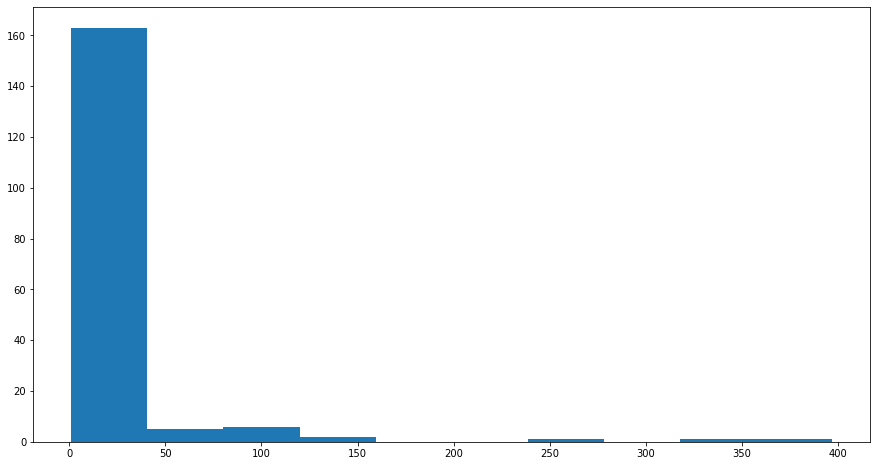

In [174]:
plt.hist(noncommlengths)

In [175]:
noncommlengths.count(1), len(noncommlengths)

(79, 179)

In [176]:
def difference_of_means(data1, data2, tails):
    n1 = len(data1)
    n2 = len(data2)
    n = n1 + n2
    x1 = np.mean(data1)
    x2 = np.mean(data2)
    s1 = np.std(data1, ddof=1) #accounts for Bessel's correction w/ ddof=1
    s2 = np.std(data2, ddof=1)
    alpha = 0.05/(len(union['holding_company_id'].unique()) + len(union['project_company_id'].unique()))
    
    se = np.sqrt(s1**2/n1 + s2**2/n2)
    t = (x2 - x1)/se
    df = min(n1,n2) - 1 # conservative estimate from OpenIntro
    pvalue = tails*stats.t.cdf(-np.abs(t), df)

    SDpooled = np.sqrt((s1**2*(n1 - 1) + s2**2*(n2 - 1))/(n1 + n2 - 2)) # OpenIntro section 5.3.6
    Cohensd = (x2 - x1)/SDpooled
    Glassd = (x2 - x1)/s2
    Hedgesg = Cohensd*((n - 3)/(n - 2.25))*np.sqrt((n - 2)/n) #multiplies Cohen's d by correction factor to get Hedge's g

    return t, pvalue, Cohensd, Hedgesg, Glassd, pvalue < alpha

In [177]:
print(f'holding id \t t-value \t\t p-value \t\t\t Glass\' delta \t\t significant?')
for i in union['holding_company_id'].unique():
    company = union[union['holding_company_id'] == i]['efficiency']
    others = union[union['holding_company_id'] != i]['efficiency']
    if difference_of_means(company, others, 2)[1] == 0.0:
        print(f'{i} \t\t {difference_of_means(company, others, 2)[0]} \t {difference_of_means(company, others, 2)[1]} \
    \t\t\t {difference_of_means(company, others, 2)[4]} \t {difference_of_means(company, others, 2)[-1]}')
    else:
        print(f'{i} \t\t {difference_of_means(company, others, 2)[0]} \t {difference_of_means(company, others, 2)[1]} \
    \t {difference_of_means(company, others, 2)[4]} \t {difference_of_means(company, others, 2)[-1]}')

holding id 	 t-value 		 p-value 			 Glass' delta 		 significant?
15 		 -6.063778069588508 	 1.4448990979412638e-09     	 -0.08360965783375976 	 True
14 		 -9.897188596852354 	 5.59264242119126e-23     	 -0.0947772608910083 	 True
3 		 6.225922424233868 	 5.028576480251243e-10     	 0.06514148494785285 	 True
6 		 4.833492946217625 	 1.5608665934487009e-06     	 0.12923839108386084 	 True
20 		 54.56384642777099 	 0.0     			 0.9146347165924525 	 True
22 		 3.2615822806392973 	 0.0011508340823085496     	 0.08474569126673125 	 False
21 		 3.4678164142565917 	 0.0005495378027049435     	 0.1061283859124675 	 False
23 		 -10.033234869841124 	 1.587311369383738e-22     	 -0.41244397790037457 	 True
9 		 -3.6921903440454313 	 0.00023077047771042944     	 -0.07696099321103811 	 True
13 		 -49.545555450592 	 0.0     			 -1.4639003719728394 	 True
17 		 15.953093524254694 	 1.5763707786915324e-50     	 0.3475653756556751 	 True
4 		 -8.022229670572223 	 3.471963316700302e-15     	 -0.230765976

In [178]:
print(f'project id \t t-value \t\t p-value \t\t\t Glass\' delta \t\t significant?')
for i in union['project_company_id'].unique():
    company = union[union['project_company_id'] == i]['efficiency']
    others = union[union['project_company_id'] != i]['efficiency']
    if difference_of_means(company, others, 2)[1] == 0.0:
        print(f'{i} \t\t {difference_of_means(company, others, 2)[0]} \t {difference_of_means(company, others, 2)[1]} \
    \t\t\t {difference_of_means(company, others, 2)[4]} \t {difference_of_means(company, others, 2)[-1]}')
    else:
        print(f'{i} \t\t {difference_of_means(company, others, 2)[0]} \t {difference_of_means(company, others, 2)[1]} \
    \t {difference_of_means(company, others, 2)[4]} \t {difference_of_means(company, others, 2)[-1]}')

project id 	 t-value 		 p-value 			 Glass' delta 		 significant?
44 		 -6.0936973630717555 	 1.2009209634400289e-09     	 -0.08401915886918528 	 True
50 		 -11.579931981226919 	 6.104976617565209e-30     	 -0.23365139312718666 	 True
43 		 -4.062694908233144 	 4.910907321229357e-05     	 -0.04663012597864799 	 True
6 		 6.1998487715150405 	 5.93393161455416e-10     	 0.0651108315812647 	 True
11 		 5.374998995620562 	 9.808275995800865e-08     	 0.15221218222462035 	 True
56 		 54.57668135745087 	 0.0     			 0.9147948243071427 	 True
61 		 3.4351971773160352 	 0.0006194985245323583     	 0.08883739560657448 	 False
57 		 3.58575688298318 	 0.0003542909880020253     	 0.11056079784552661 	 True
49 		 -4.246313119148326 	 2.3703432724120137e-05     	 -0.11026777559278077 	 True
64 		 -10.033234869841124 	 1.587311369383738e-22     	 -0.41244397790037457 	 True
20 		 -2.0970015270233016 	 0.03626771002306273     	 -0.053406305430906395 	 False
41 		 -47.31991478015743 	 0.0     			 -1.34

In [179]:
print('alpha = ' + str(0.05/(len(union['holding_company_id'].unique()) + len(union['project_company_id'].unique()))))

alpha = 0.0004098360655737705


In [180]:
len(union[union['holding_company_id'] == 20]['efficiency'])

4431

In [181]:
np.mean(union[union['holding_company_id'] == 20]['efficiency'])

0.4616528119097915

In [182]:
np.mean(union[union['holding_company_id'] != 20]['efficiency'])

0.8873991575018865

In [183]:
np.mean(union['efficiency'])

0.8635885637232005

(array([2086.,   63.,   80.,  107.,  126.,  138.,  114.,  165.,  168.,
         193.,  237.,  235.,  232.,  192.,  140.,   65.,   41.,   18.,
          16.,    4.]),
 array([0.        , 0.09135854, 0.18271708, 0.27407563, 0.36543417,
        0.45679271, 0.54815125, 0.6395098 , 0.73086834, 0.82222688,
        0.91358542, 1.00494397, 1.09630251, 1.18766105, 1.27901959,
        1.37037814, 1.46173668, 1.55309522, 1.64445376, 1.73581231,
        1.82717085]),
 <a list of 20 Patch objects>)

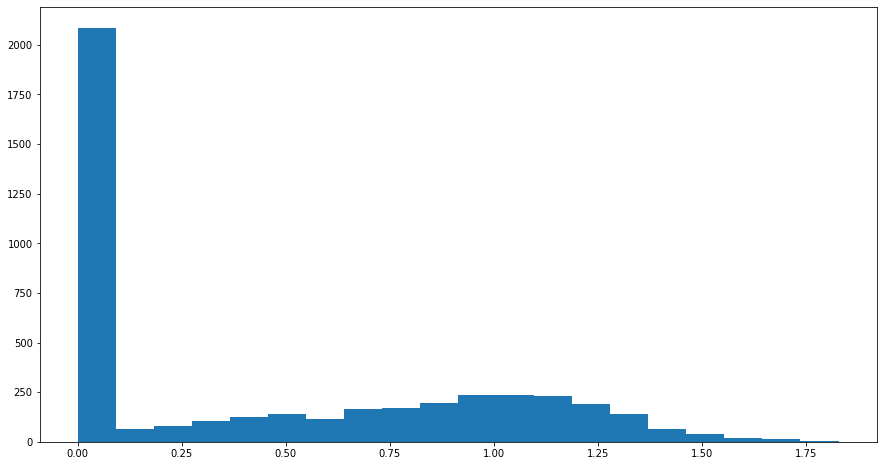

In [184]:
plt.hist(union[union['holding_company_id'] == 20]['efficiency'], bins = 20)

(array([3977., 2948., 2964., 3754., 3871., 3641., 3780., 4793., 5476.,
        6016., 6979., 7118., 6196., 4620., 2909., 1835.,  985.,  579.,
         257., 1914.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 20 Patch objects>)

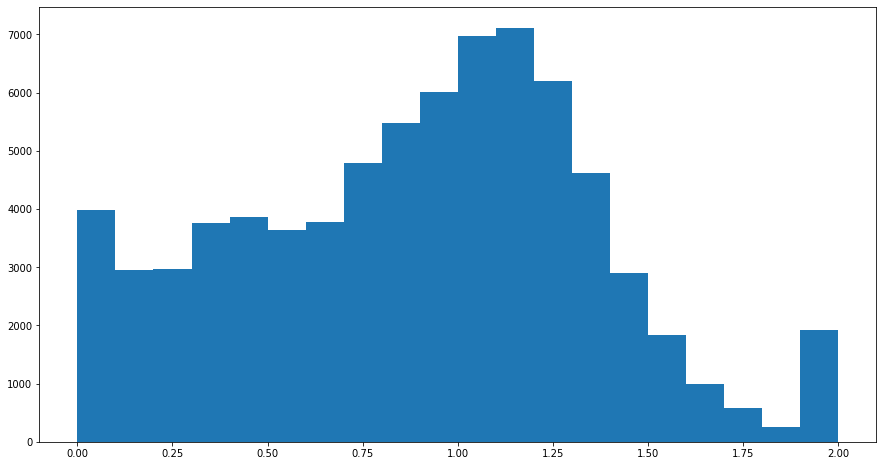

In [185]:
plt.hist(union[union['holding_company_id'] != 20]['efficiency'], bins = 20)

In [186]:
from statsmodels.formula.api import ols

anova = ols('efficiency ~ C(holding_company_id)', data=union).fit()
anova_table = statsmodels.stats.anova_lm(anova, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(holding_company_id),2026.309817,33.0,302.532768,0.0
Residual,16033.767577,78998.0,NaN,NaN


In [187]:
from statsmodels.formula.api import ols

anova = ols('efficiency ~ C(project_company_id)', data=union).fit()
anova_table = statsmodels.stats.anova_lm(anova, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(project_company_id),2135.829453,87.0,121.704746,0.0
Residual,15924.247941,78944.0,NaN,NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             efficiency   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 30 Jul 2021   Prob (F-statistic):                nan
Time:                        15:57:31   Log-Likelihood:                -159.77
No. Observations:                 443   AIC:                             321.5
Df Residuals:                     442   BIC:                             325.6
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
size_kwdc      0.0089      0.000     50.627      0.000       0.009       0.009
==============================================================================
Omnibus:                       12.411   Durbin-Watson:                   1.400
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                9.959
Skew:                          -0.279   Prob(JB):                      0.00688
Kurtosis:                       2.521   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

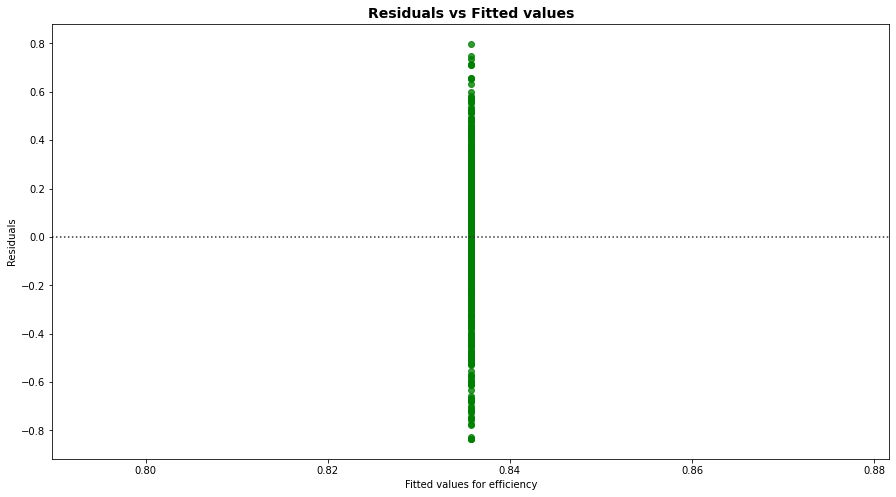

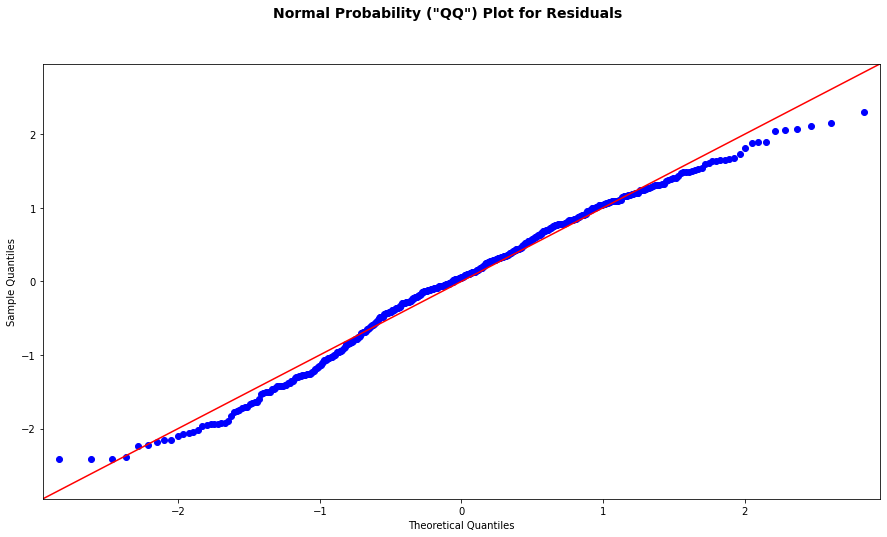

In [188]:
type(mult_regression(union.dropna(), 'size_kwdc', 'efficiency'))
regressionmodel.summary()

In [189]:
stats.linregress(union.dropna()['h20'], union.dropna()['efficiency'])

LinregressResult(slope=nan, intercept=nan, rvalue=0.0, pvalue=1.0, stderr=inf)

In [190]:
union[union['efficiency'].isna()]

,holding_company_id,project_company_id,contract_id,size_kwdc,created_on,updated_on,production_date,ato_date,actual_kwh,expected_kwh,...,p83,p84,p85,p86,p87,p88,yield,efficiency,production_days,ato_days
0,15,44,4FbAzTVD,25.13,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01,2018-11-29,NaN,42.908097,...,0,0,0,0,0,0,NaN,NaN,12.0,344.0
1,14,50,56XBWDhT,40.00,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01,2018-09-28,NaN,71.340590,...,0,0,0,0,0,0,NaN,NaN,12.0,282.0
4,15,44,8GniqiNd,77.52,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01,2018-07-12,NaN,142.074655,...,0,0,0,0,0,0,NaN,NaN,12.0,204.0
7,14,43,bTUPD3c4,26.20,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01,2018-09-28,NaN,49.671516,...,0,0,0,0,0,0,NaN,NaN,12.0,282.0
16,15,44,Jx3DJ5Kn,51.59,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01,2018-07-12,NaN,97.900512,...,0,0,0,0,0,0,NaN,NaN,12.0,204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84211,36,85,ZPBWCX32,65.90,2021-06-18 05:16:40.411532,2021-06-18 05:17:52.986922,2021-06-18,2021-05-14,NaN,302.640782,...,0,0,1,0,0,0,NaN,NaN,181.0,146.0
84212,30,77,ZTgGZhSt,46.10,2021-06-18 05:16:40.411532,2021-06-18 05:17:52.986922,2021-06-18,2021-02-17,NaN,231.249615,...,0,0,0,0,0,0,NaN,NaN,181.0,60.0
84213,24,48,zvKpFwPG,28.80,2021-06-18 05:16:40.411532,2021-06-18 05:17:52.986922,2021-06-18,2020-03-12,NaN,137.936273,...,0,0,0,0,0,0,NaN,NaN,181.0,83.0
84214,30,77,ZvSGESam,45.00,2021-06-18 05:16:40.411532,2021-06-18 05:17:52.986922,2021-06-18,2020-12-14,NaN,226.065142,...,0,0,0,0,0,0,NaN,NaN,181.0,360.0


In [192]:
temp = union.dropna()[holding_ids.columns]
temp['efficiency'] = union['efficiency']

X = temp[holding_ids.columns].to_numpy()
y = temp['efficiency'].to_numpy()

temp.head()

,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,...,h27,h28,h29,h30,h31,h32,h33,h35,h36,efficiency
23031,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.596568
23132,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.902953
23233,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.957237
23334,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.479892
23435,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.734132


In [193]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [200]:
regr.coef_
regr.score(X, y)

0.001011401142016366

In [194]:
testarray = np.array([0 for i in range(34)])
testarray[13] = 1
regr.predict(testarray.reshape(1, -1))

array([0.89160156])

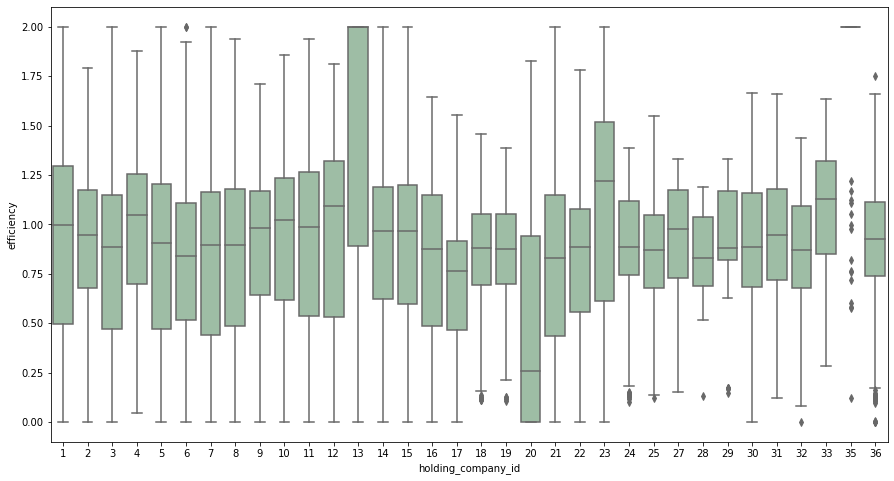

In [195]:
ax = sns.boxplot(x='holding_company_id', y='efficiency', data=union, color='#99c2a2')
plt.show()

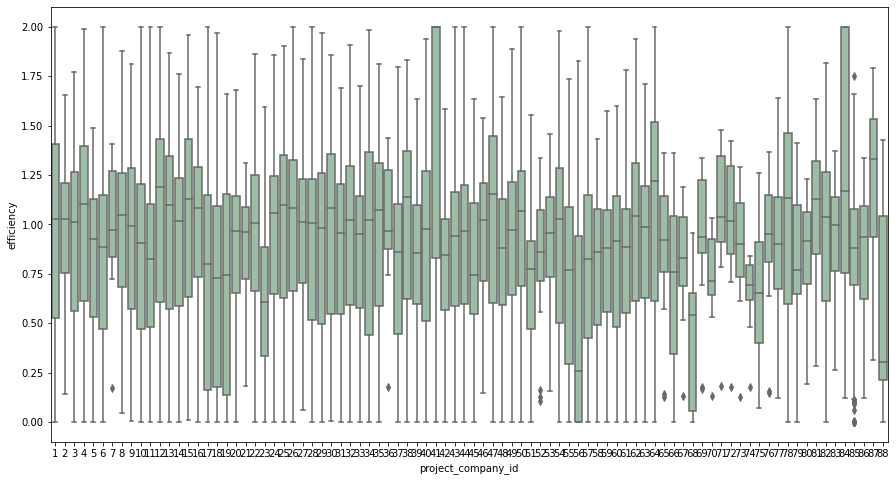

In [196]:
ax = sns.boxplot(x='project_company_id', y='efficiency', data=union, color='#99c2a2')
plt.show()

KeyboardInterrupt: 

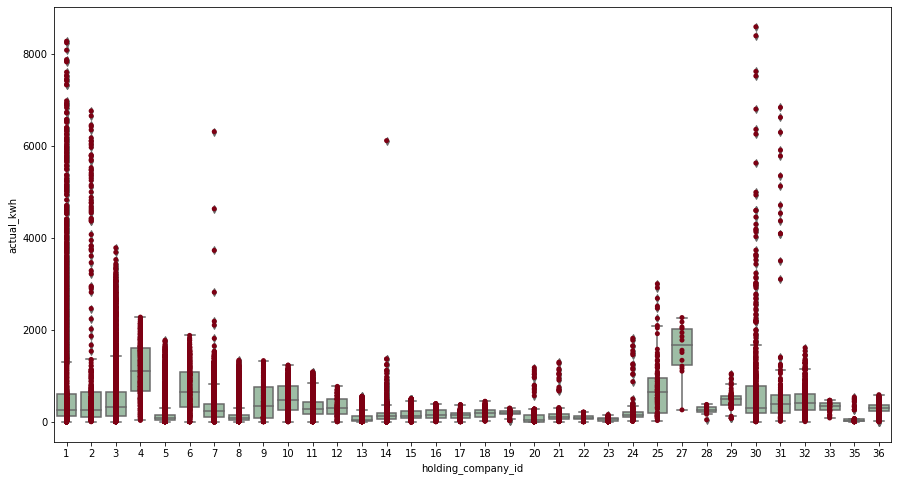

In [197]:
hax = sns.boxplot(x='holding_company_id', y='actual_kwh', data=union, color='#99c2a2')
hax = sns.swarmplot(x="holding_company_id", y="actual_kwh", data=union, color='#7d0013')
plt.show()

In [ ]:
from kats.models.sarima import SARIMAModel, SARIMAParams
warnings.simplefilter(action='ignore')

# create SARIMA param class
sparams = SARIMAParams(p = 2, d = 1, q = 1, trend = 'ct', seasonal_order = (1, 0, 1, 12))

# initiate SARIMA model
sm = SARIMAModel(data=forecast, params=sparams)

# fit SARIMA model
sm.fit()

# generate forecast values
sfcst = sm.predict(steps=30, freq="MS")

# make plot to visualize
sm.plot()